# Предсказание температуры стали

<a id=1></a>
## Описание проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc_new.csv` — данные об электродах;
- `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time_new.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas_new.csv` — данные о продувке сплава газом;
- `data_temp_new.csv` — результаты измерения температуры;
- `data_wire_new.csv` — данные о проволочных материалах (объём);
- `data_wire_time_new.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

## План проекта

**1. Проведение обзора данных (EDA)**

**Подготовка данных:** 
* Импорт необходимых библиотек;
* Чтение файлов и сохранение полученных данных в переменные;
* Получение общей информации о таблицах (head, info, describe);
* Корректировка наименований столбцов (при необходимости).
* Выводы

**Анализ данных:**
* Графическое представление данных из таблиц;
* Проверка данных на аномалии.
* Выводы

**Предобработка данных:**
* Корректировка типов данных (при необходимости)
* Заполнение пропусков / удаление дубликатов (при наличии)
* Добавление признаков
* Агрегирование по ключу
* Соединение таблиц
* Выделение признаков и таргета
* Выводы;

**Исследование итоговой таблицы с данными:**
* Аналитический анализ
* графический анализ
* корреляционный анализ
* выводы

**2. Построение модели машинного обучения**

**Обучение модели:**
* Разделение данных на обучающую и тестовую выборки;
* Масштабирование данных;
* Обучение модели линейной регрессии;
* Обучение модели решающих деревьев;
* Обучение модели случайного леса;
* Обучение модели градиентного бустинга с перебором гиперпараметров - LGBM;
* Обучение модели градиентного бустинга с перебором гиперпараметров - CatBoost;
* Обучение константной модели;
* Выбор лучшей модели.

**Проверка лучшей  модели:**
* Тестирование лучшей модели на тестовой выборке;
* Если MAE на тестовых данных > 6.8 - доработка модели.
* Анализ важности факторов
* Выводы

**3. Отчёт. Общий вывод**

## 1. Проведение обзора данных (EDA)

### 1.1. Подготовка данных

#### 1.1.1. Импорт необходимых библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import seaborn as sns
import plotly.express as px 
import datetime as dt
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

# вспомогательные инструменты
from sklearn.preprocessing import StandardScaler # для масштабирования количественных признаков
from sklearn.model_selection import train_test_split # деление на 2 выборки
from sklearn.model_selection import GridSearchCV # для поиска оптимальных параметров

# модели для обучения
from sklearn.linear_model import LinearRegression # линейная регрессия
from sklearn.tree import DecisionTreeRegressor # решающее дерево
from sklearn.ensemble import RandomForestRegressor # случайный лес
from sklearn.dummy import DummyRegressor # константная модель

# модели градиентного бустинга
import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# метрики
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error

import shap
shap.initjs()

import time

In [2]:
!pip install shap

#### 1.1.2. Чтение файлов и сохранение полученных данных в переменные

In [3]:
try:
    data_arc = pd.read_csv('datasets/final_steel/data_arc_new.csv', sep=',')
    data_bulk = pd.read_csv('datasets/final_steel/data_bulk_new.csv', sep=',')
    data_bulk_time = pd.read_csv('datasets/final_steel/data_bulk_time_new.csv', sep=',')
    data_gas = pd.read_csv('datasets/final_steel/data_gas_new.csv', sep=',')
    data_temp = pd.read_csv('datasets/final_steel/data_temp_new.csv', sep=',')
    data_wire = pd.read_csv('datasets/final_steel/data_wire_new.csv', sep=',')
    data_wire_time = pd.read_csv('datasets/final_steel/data_wire_time_new.csv', sep=',')
except:
    data_arc = pd.read_csv('/datasets/data_arc_new.csv', sep=',')
    data_bulk = pd.read_csv('/datasets/data_bulk_new.csv', sep=',')
    data_bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv', sep=',')
    data_gas = pd.read_csv('/datasets/data_gas_new.csv', sep=',')
    data_temp = pd.read_csv('/datasets/data_temp_new.csv', sep=',')
    data_wire = pd.read_csv('/datasets/data_wire_new.csv', sep=',')
    data_wire_time = pd.read_csv('/datasets/data_wire_time_new.csv', sep=',')

#### 1.1.3. Получение общей информации о таблицах (head, info, describe)

##### Данные об электродах

In [4]:
data_arc.head()

key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.305130   
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.765658   
2    1  2019-05-03 11:11:44  2019-05-03 11:14:36           0.580313   
3    1  2019-05-03 11:18:14  2019-05-03 11:24:19           0.518496   
4    1  2019-05-03 11:26:09  2019-05-03 11:28:37           0.867133   

   Реактивная мощность  
0             0.211253  
1             0.477438  
2             0.430460  
3             0.379979  
4             0.643691

Данные загружены нормально.

In [5]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


Пропусков нет. 

Есть время начала и конца нагрева, следовательно, мы можем посчитать сколько длился каждый нагрев. 

Также есть активная и реактивная мощности. Из [физики известно](https://m-strana.ru/articles/aktivnaya-i-reaktivnaya-moshchnost/), что активная и реактивная мощность взаимосвязаны. По ним мржно будет вычислить полную мощность. Исходя из полученных данных, активная мощность скорей всего приведена в МВт, а реактивная - в МВар.

In [6]:
print('Всего партий', len(data_arc['key'].value_counts()))
print('Максимальный номер партии',data_arc['key'].max())

Всего партий 3214
Максимальный номер партии 3241


Всего в выборке с нагревом электродов есть данные по 3214 партиям, хотя датасет заканчивается 3241, из чего можно сделать вывод, что по каким-то партиям данные не вошли в датасет, возможно они были забракованы. 

У некоторых партие есть несколлько этапов нагрева, а каких-то по одному.

Проверим описательные статистики по нагреву.

In [7]:
data_arc.describe()

key  Активная мощность  Реактивная мощность
count  14876.000000       14876.000000         14876.000000
mean    1615.220422           0.662752             0.438986
std      934.571502           0.258885             5.873485
min        1.000000           0.223120          -715.479924
25%      806.000000           0.467115             0.337175
50%     1617.000000           0.599587             0.441639
75%     2429.000000           0.830070             0.608201
max     3241.000000           1.463773             1.270284

Активная мощность не имеет сильных выбросов: её минимум и максимум положительные, а 1 и 3 квартили находятся в пределах 0.46 и 0.83 соотвественно.

У реактивной мощности большая часть данных находится в пределах 0,29 - 0,63 (1 и 3 квартили). При этом имеется отрицательное минимальное значение, равное -715.5 МВар. Обратим на это внимание, когда будем посмотреть распределения этих двух параметров. 
Сейчас же посмотрим на данные выбросы - выведем все отрицательные значения реактивной мощности.

In [8]:
data_arc[data_arc['Реактивная мощность'] < 0]

key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
9780  2116  2019-07-28 02:22:08  2019-07-28 02:23:57           0.705344   

      Реактивная мощность  
9780          -715.479924

Есть только одна строка с отрицательным значением. Выведем всю информацию по этой партии (2116).

In [9]:
data_arc[data_arc['key'] == 2116]

key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
9778  2116  2019-07-28 02:07:12  2019-07-28 02:09:14           0.787549   
9779  2116  2019-07-28 02:13:10  2019-07-28 02:15:25           0.580263   
9780  2116  2019-07-28 02:22:08  2019-07-28 02:23:57           0.705344   
9781  2116  2019-07-28 02:29:11  2019-07-28 02:30:18           0.563641   

      Реактивная мощность  
9778             0.693881  
9779             0.411498  
9780          -715.479924  
9781             0.408513

Скорей всего, такое значение реактивной мощности является просто выбросом.

##### Данные о подаче сыпучих материалов (объём)

В датасете одна строка представляет информацию по объему сыпучих материалов, добавленных в течение всего технологического процесса.

In [10]:
data_bulk.head()

key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1    2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2    3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   
3    4     NaN     NaN     NaN    81.0     NaN     NaN     NaN     NaN   
4    5     NaN     NaN     NaN    78.0     NaN     NaN     NaN     NaN   

   Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0     NaN      NaN      NaN    206.0      NaN    150.0    154.0  
1     NaN      NaN      NaN    206.0      NaN    149.0    154.0  
2     NaN      NaN      NaN    205.0      NaN    152.0    153.0  
3     NaN      NaN      NaN    207.0      NaN    153.0    154.0  
4     NaN      NaN      NaN    203.0      NaN    151.0    152.0

In [11]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


Состав добавления сыпучих материалов неодинаков и меняется в зависимости от того, когда партия достигает целевого химического сотава.

Пропуски в данных означают, что данная присадка не добавлялась для этой конкретной партии, поэтому можно их заменить на 0.

In [12]:
data_bulk.describe()

key      Bulk 1      Bulk 2       Bulk 3       Bulk 4  \
count  3129.000000  252.000000   22.000000  1298.000000  1014.000000   
mean   1624.383509   39.242063  253.045455   113.879045   104.394477   
std     933.337642   18.277654   21.180578    75.483494    48.184126   
min       1.000000   10.000000  228.000000     6.000000    12.000000   
25%     816.000000   27.000000  242.000000    58.000000    72.000000   
50%    1622.000000   31.000000  251.500000    97.500000   102.000000   
75%    2431.000000   46.000000  257.750000   152.000000   133.000000   
max    3241.000000  185.000000  325.000000   454.000000   281.000000   

           Bulk 5      Bulk 6      Bulk 7  Bulk 8      Bulk 9     Bulk 10  \
count   77.000000  576.000000   25.000000     1.0   19.000000  176.000000   
mean   107.025974  118.925347  305.600000    49.0   76.315789   83.284091   
std     81.790646   72.057776  191.022904     NaN   21.720581   26.060347   
min     11.000000   17.000000   47.000000    49.0   63.000000   24.000000   
25%     70.000000   69.750000  155.000000    49.0   66.000000   64.000000   
50%     86.000000  100.000000  298.000000    49.0   68.000000   86.500000   
75%    132.000000  157.000000  406.000000    49.0   70.500000  102.000000   
max    603.000000  503.000000  772.000000    49.0  147.000000  159.000000   

          Bulk 11      Bulk 12     Bulk 13      Bulk 14      Bulk 15  
count  177.000000  2450.000000   18.000000  2806.000000  2248.000000  
mean    76.819209   260.471020  181.111111   170.284747   160.513345  
std     59.655365   120.649269   46.088009    65.868652    51.765319  
min      8.000000    53.000000  151.000000    16.000000     1.000000  
25%     25.000000   204.000000  153.250000   119.000000   105.000000  
50%     64.000000   208.000000  155.500000   151.000000   160.000000  
75%    106.000000   316.000000  203.500000   205.750000   205.000000  
max    313.000000  1849.000000  305.000000   636.000000   405.000000

In [13]:
print('Всего партий', len(data_bulk['key'].value_counts()))
print('Максимальный номер партии',data_bulk['key'].max())

Всего партий 3129
Максимальный номер партии 3241


Данные по присадкам опять представлены не по всем партиям, это следует учесть при составлении единого датасета со всеми данными.

##### Данные о подаче сыпучих материалов (время)

Посмотрим на данные со временем добавления сыпучих материалов.

In [14]:
data_bulk_time.head()

key Bulk 1 Bulk 2 Bulk 3               Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8  \
0    1    NaN    NaN    NaN  2019-05-03 11:28:48    NaN    NaN    NaN    NaN   
1    2    NaN    NaN    NaN  2019-05-03 11:36:50    NaN    NaN    NaN    NaN   
2    3    NaN    NaN    NaN  2019-05-03 12:32:39    NaN    NaN    NaN    NaN   
3    4    NaN    NaN    NaN  2019-05-03 12:43:22    NaN    NaN    NaN    NaN   
4    5    NaN    NaN    NaN  2019-05-03 13:30:47    NaN    NaN    NaN    NaN   

  Bulk 9 Bulk 10 Bulk 11              Bulk 12 Bulk 13              Bulk 14  \
0    NaN     NaN     NaN  2019-05-03 11:24:31     NaN  2019-05-03 11:14:50   
1    NaN     NaN     NaN  2019-05-03 11:53:30     NaN  2019-05-03 11:48:37   
2    NaN     NaN     NaN  2019-05-03 12:27:13     NaN  2019-05-03 12:21:01   
3    NaN     NaN     NaN  2019-05-03 12:58:00     NaN  2019-05-03 12:51:11   
4    NaN     NaN     NaN  2019-05-03 13:30:47     NaN  2019-05-03 13:34:12   

               Bulk 15  
0  2019-05-03 11:10:43  
1  2019-05-03 11:44:39  
2  2019-05-03 12:16:16  
3  2019-05-03 12:46:36  
4  2019-05-03 13:30:47

In [15]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [16]:
print('Всего партий', len(data_bulk_time['key'].value_counts()))
print('Максимальный номер партии',data_bulk_time['key'].max())

Всего партий 3129
Максимальный номер партии 3241


Видим, что данные о времени добавления сыпучих материалов имеют ту же структуру, что и данные об объеме этих материалов. Т.к. данная задача не на временные ряды, данные о времени в общий датасет включаться не будут.

##### Данные о продувке сплава газом

In [17]:
data_gas.head()

key      Газ 1
0    1  29.749986
1    2  12.555561
2    3  28.554793
3    4  18.841219
4    5   5.413692

In [18]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


Газ добавляется в каждую партию без исключений - нулевые значения отсутствуют.

In [19]:
data_gas.describe()

key        Газ 1
count  3239.000000  3239.000000
mean   1621.861377    11.002062
std     935.386334     6.220327
min       1.000000     0.008399
25%     812.500000     7.043089
50%    1622.000000     9.836267
75%    2431.500000    13.769915
max    3241.000000    77.995040

In [20]:
print('Всего партий', len(data_gas['key'].value_counts()))
print('Максимальный номер партии',data_gas['key'].max())

Всего партий 3239
Максимальный номер партии 3241


Пропуски в данных по газу отсутствуют, по количеству партий данный параметр заполнен наиболее полно по сравнению со всеми рассмотренными выше параметрами. Нехватает всего двух партий.

##### Данные о проволочных материалах (объём)

Проведем исследование данных аналогично сыпучим материалам.

In [21]:
data_wire.head()

key     Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
0    1  60.059998      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1    2  96.052315      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2    3  91.160157      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3    4  89.063515      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4    5  89.238236  9.11456     NaN     NaN     NaN     NaN     NaN     NaN   

   Wire 9  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN

In [22]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [23]:
print('Всего партий', len(data_wire['key'].value_counts()))
print('Максимальный номер партии',data_wire['key'].max())

Всего партий 3081
Максимальный номер партии 3241


Аналогично сыпучим материалам объем материалов разнится в зависимости от партии. 

Пропуски в данных в каком либо столбце означают отсутствие добавления этого материала для этой партии, поэтому также могут быть заменены нулями, как в случае с сыпучими материалами.

Данные об объемах проволочных материалов рассмотрены.

##### Данные о проволочных материалах (время)

Посмотрим на данные о времени их добавления.

In [24]:
data_wire_time.head()

key               Wire 1               Wire 2 Wire 3 Wire 4 Wire 5 Wire 6  \
0    1  2019-05-03 11:06:19                  NaN    NaN    NaN    NaN    NaN   
1    2  2019-05-03 11:36:50                  NaN    NaN    NaN    NaN    NaN   
2    3  2019-05-03 12:11:46                  NaN    NaN    NaN    NaN    NaN   
3    4  2019-05-03 12:43:22                  NaN    NaN    NaN    NaN    NaN   
4    5  2019-05-03 13:20:44  2019-05-03 13:15:34    NaN    NaN    NaN    NaN   

  Wire 7 Wire 8 Wire 9  
0    NaN    NaN    NaN  
1    NaN    NaN    NaN  
2    NaN    NaN    NaN  
3    NaN    NaN    NaN  
4    NaN    NaN    NaN

In [25]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


Данные о времени добавления проволочных материалов идентичны по структуре данным с объемами материалов. Аналогично сыпучим материалам данные о времени в общий датасет не добавляем, следовательно и не обрабатываем.

##### Результаты измерения температуры



In [26]:
data_temp.head()

key         Время замера  Температура
0    1  2019-05-03 11:02:04       1571.0
1    1  2019-05-03 11:07:18       1604.0
2    1  2019-05-03 11:11:34       1618.0
3    1  2019-05-03 11:18:04       1601.0
4    1  2019-05-03 11:25:59       1606.0

In [27]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


Для двух тысяч строк данные пропущены, несмотря на то, что указано время замера. Следует проверить количество измерений по каждой партии.

In [28]:
data_temp.describe()

key   Температура
count  18092.000000  14665.000000
mean    1616.460977   1590.722741
std      934.641385     20.394381
min        1.000000   1191.000000
25%      807.750000   1580.000000
50%     1618.000000   1590.000000
75%     2429.000000   1599.000000
max     3241.000000   1705.000000

Посмотрим на данные с пропусками.

In [29]:
data_temp[data_temp['Температура'].isna()].head(10)

key         Время замера  Температура
13927  2500  2019-08-10 14:13:11          NaN
13928  2500  2019-08-10 14:18:12          NaN
13929  2500  2019-08-10 14:25:53          NaN
13930  2500  2019-08-10 14:29:39          NaN
13932  2501  2019-08-10 14:49:15          NaN
13933  2501  2019-08-10 15:02:56          NaN
13934  2501  2019-08-10 15:07:47          NaN
13935  2501  2019-08-10 15:16:53          NaN
13936  2501  2019-08-10 15:22:50          NaN
13937  2501  2019-08-10 15:29:00          NaN

Для партий, где измерения полные, будем оставлять начльную температуру в качестве обучающего признака и последнюю температуру в качестве таргета.

Удаляем пропуски, поскольку они для нас бесполезны: из них нельзя узнать ни начальной, ни конечной температурф.

In [30]:
data_temp = data_temp.dropna()

Проверим результат.

In [31]:
data_temp[data_temp['Температура'].isna()].head(10)

Empty DataFrame
Columns: [key, Время замера, Температура]
Index: []

Отлично, пропуски удалены.

Первичное ознакомление с данными закончено.

#### 1.1.4. Корректировка наименований столбцов

Изменим названия в столбцах данных. Переименуем столбцы, потому что некоторые алгоритмы не воспринимают русский текст.

##### Данные об электродах

In [32]:
list(data_arc.columns)

['key',
 'Начало нагрева дугой',
 'Конец нагрева дугой',
 'Активная мощность',
 'Реактивная мощность']

In [33]:
new_columns = {'key':'key','Начало нагрева дугой': 'start_of_arc_heating',
              'Конец нагрева дугой': 'end_of_arc_heating',
              'Активная мощность': 'active_power', 
               'Реактивная мощность': 'reactive_power'}

In [34]:
data_arc = data_arc.rename(columns=new_columns)

In [35]:
data_arc.columns

Index(['key', 'start_of_arc_heating', 'end_of_arc_heating', 'active_power',
       'reactive_power'],
      dtype='object')

##### Данные о подаче сыпучих материалов (объём)

In [36]:
data_bulk.columns

Index(['key', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6',
       'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12',
       'Bulk 13', 'Bulk 14', 'Bulk 15'],
      dtype='object')

In [37]:
new_columns = {'Bulk 1': 'bulk_1', 'Bulk 2': 'bulk_2', 'Bulk 3': 'bulk_3', 'Bulk 4': 'bulk_4', 'Bulk 5': 'bulk_5', 
               'Bulk 6': 'bulk_6', 'Bulk 7': 'bulk_7', 'Bulk 8': 'bulk_8', 'Bulk 9': 'bulk_9', 'Bulk 10': 'bulk_10', 
               'Bulk 11': 'bulk_11', 'Bulk 12': 'bulk_12', 'Bulk 13': 'bulk_13', 'Bulk 14': 'bulk_14', 'Bulk 15': 'bulk_15'}

In [38]:
data_bulk = data_bulk.rename(columns=new_columns)

In [39]:
data_bulk.columns

Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15'],
      dtype='object')

##### Данные о подаче сыпучих материалов (время)

Нет необходимости.

##### Данные о продувке сплава газом

In [40]:
data_gas.columns

Index(['key', 'Газ 1'], dtype='object')

In [41]:
data_gas = data_gas.rename(columns={'Газ 1':'gas'})

In [42]:
data_gas.columns

Index(['key', 'gas'], dtype='object')

In [43]:
data_gas

key        gas
0        1  29.749986
1        2  12.555561
2        3  28.554793
3        4  18.841219
4        5   5.413692
...    ...        ...
3234  3237   5.543905
3235  3238   6.745669
3236  3239  16.023518
3237  3240  11.863103
3238  3241  12.680959

[3239 rows x 2 columns]

##### Данные о проволочных материалах (объём)

In [44]:
data_wire.columns

Index(['key', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6',
       'Wire 7', 'Wire 8', 'Wire 9'],
      dtype='object')

In [45]:
new_columns = {'Wire 1': 'wire_1', 'Wire 2': 'wire_2', 'Wire 3': 'wire_3', 
                'Wire 4': 'wire_4', 'Wire 5': 'wire_5', 'Wire 6': 'wire_6', 
                'Wire 7': 'wire_7', 'Wire 8': 'wire_8', 'Wire 9': 'wire_9'}

In [46]:
data_wire = data_wire.rename(columns=new_columns)

In [47]:
data_wire.columns

Index(['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9'],
      dtype='object')

##### Данные о проволочных материалах (время)

Нет необходимости.

##### Результаты измерения температуры

In [48]:
data_temp.columns

Index(['key', 'Время замера', 'Температура'], dtype='object')

In [49]:
new_columns = {'Время замера': 'measurement_time', 'Температура': 'temperature'}

In [50]:
data_temp = data_temp.rename(columns=new_columns)

In [51]:
data_temp.columns

Index(['key', 'measurement_time', 'temperature'], dtype='object')

#### 1.1.5. Выводы

* данные ноомально загружены;
* в данных по реактивной мощности есть подозрение на выброс;
* у материалов замечены пропуски в данных, которые вполне можно заполнить нулями;
* у замеров температуры удалены данные с пропусками, т.к. они не несуть информации;
* во многих данных имеется определённое число забракованных партий, данные по которым отсутствуют. Лучше всего представлены данные по продувке газом.
* Для удобства анализа некоторые наименования столбцов были скорректированы.

### 1.2. Анализ данных

Проведём визуальный анализ данных и удалим выбросы там, где это необходимо.

#### 1.2.1. Графическое представление данных из таблиц

##### Данные об электродах

Посмотрим на распределение активной и реактивной мощностей. 

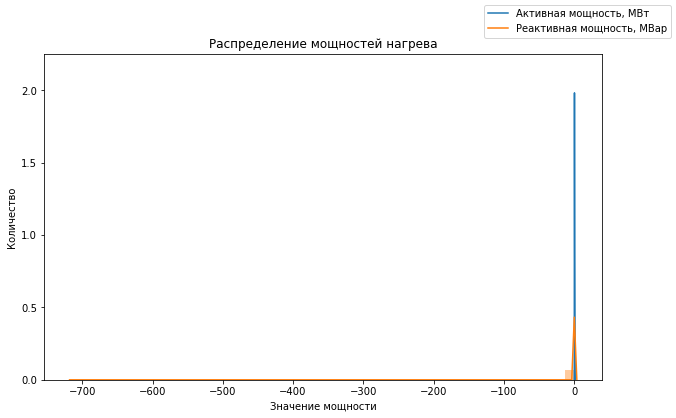

In [52]:
fig = plt.figure(figsize=(10,6)) 
sns.distplot(data_arc['active_power'])
sns.distplot(data_arc['reactive_power'])
plt.xlabel("Значение мощности")
plt.ylabel("Количество")
plt.title("Распределение мощностей нагрева")
fig.legend(labels=['Активная мощность, МВт','Реактивная мощность, МВар'])
plt.show()

Определённо, это отрицательное значение реактивной мощности является выбросом.

##### Данные о подаче сыпучих материалов (объём)

Проверим даннык на предмет выбросов.

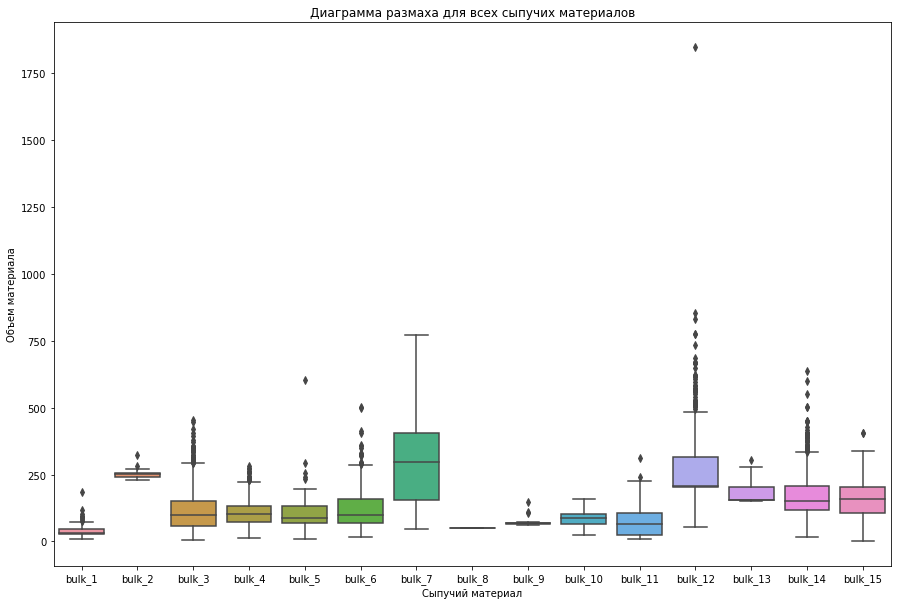

In [53]:
fig = plt.figure(figsize=(15,10))
sns.boxplot(data=data_bulk.drop('key', axis=1))
plt.xlabel("Сыпучий материал")
plt.ylabel("Объем материала")
plt.title("Диаграмма размаха для всех сыпучих материалов")
plt.show()

Из диаграммы размаха видно, что существенные выбросы имеются только для присадок 5 и 12. Вполне возможно, что данные партии потребовали большее количество сыпучих материлов по сравнению со всеми остальными, поэтому удалять такие данные нецелесообразно.

##### Данные о подаче сыпучих материалов (время)

Нет необходимости.

##### Данные о продувке сплава газом

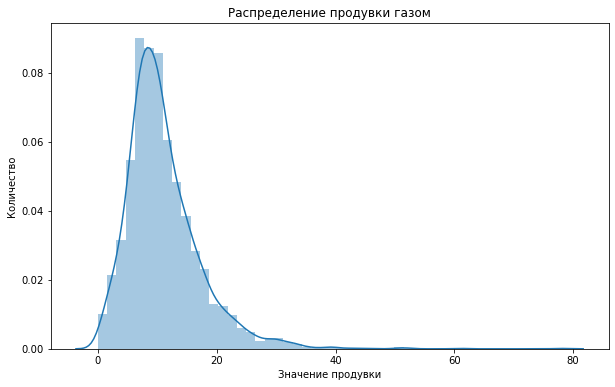

In [54]:
fig = plt.figure(figsize=(10,6))
sns.distplot(data_gas['gas'])
plt.xlabel("Значение продувки")
plt.ylabel("Количество")
plt.title("Распределение продувки газом")
plt.show()

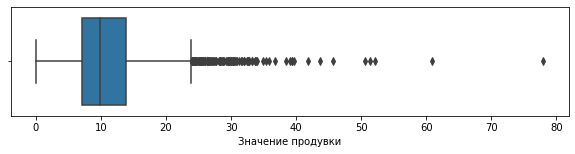

In [55]:
fig = plt.figure(figsize=(10,2))
sns.boxplot(data_gas['gas'])
plt.xlabel("Значение продувки")
plt.show()

Объем газа имеет нормальное распределение слегка скошенное вправо.

##### Данные о проволочных материалах (объём)

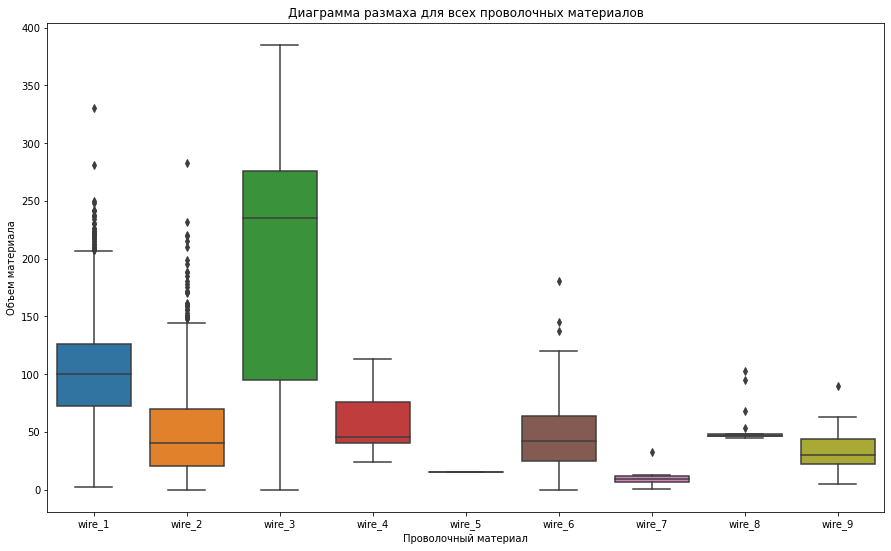

In [56]:
fig = plt.figure(figsize=(15,9))
sns.boxplot(data=data_wire.drop('key', axis=1))
plt.xlabel("Проволочный материал")
plt.ylabel("Объем материала")
plt.title("Диаграмма размаха для всех проволочных материалов")
plt.show()

Значительные выбросы замечены только для проволочного материала № 8. Он добавлялся всего в 19 партий, поэтому выбросы могут быть обусловлены просто небольшим количеством данных по данному материалу.

##### Данные о проволочных материалах (время)

Нет необходимости.

##### Результаты измерения температуры

Text(0.5, 1.0, 'Распределение замеров температуры')

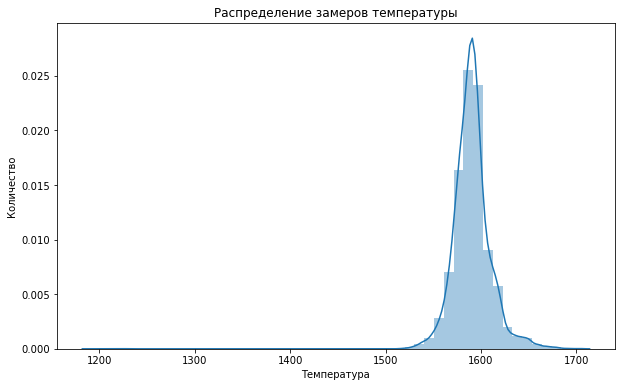

In [57]:
fig = plt.figure(figsize=(10,6))
sns.distplot(data_temp['temperature'].dropna())
plt.xlabel('Температура')
plt.ylabel("Количество")
plt.title("Распределение замеров температуры")

Text(0.5, 1.0, 'Диаграмма размаха температуры плавления')

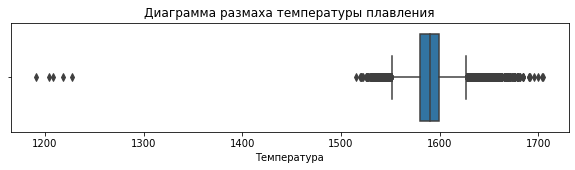

In [58]:
fig = plt.figure(figsize=(10,2))
sns.boxplot(data_temp['temperature'])
plt.xlabel('Температура')
plt.title("Диаграмма размаха температуры плавления")

Диаграммы распределения и размаха показали, что все измерения меньше 1400 градусов можно отнести к выбросам. Из данных задачи известно, что в ковш заливается расплавленная сталь. [Известно](https://ru.wikipedia.org/wiki/Сталь#:~:text=Температура%20плавления%3A%201450—1520%20°C.%20Удельная,теплопроводности%20при%20температуре%20100%20°C%3A) , что температура плавления стали находится в пределах от 1450 до 1520 градусов Цельсия. В связи с этим все данные, где температура стали меньше 1400 градусов могут быть отнесены к нецелевым и удалены из датасета о температуре.

#### 1.2.2. Проверка данных на аномалии

##### Данные об электродах

Выше мы прелположили, что в данных по реактивной мощности имеется выброс. Чтобы не терять данные по всей партии, мы заменим его средним значением по данной партии без учета выброса.

In [59]:
mean_r_power = data_arc[(data_arc['key'] == 2116) & (data_arc['reactive_power'] > 0)]['reactive_power'].mean()
data_arc.loc[9780, 'reactive_powerть'] = mean_r_power

##### Данные о подаче сыпучих материалов (объём)

Есть два выброса, но убирать их нецелесообразно.

##### Данные о подаче сыпучих материалов (время)

Нет необходимости.

##### Данные о продувке сплава газом

Выбросы отсутствуют.

##### Данные о проволочных материалах (объём)

Есть выбросы, но убирать их нецелесообразно.

##### Данные о проволочных материалах (время)

Нет необходимости.

##### Результаты измерения температуры

Уберём все значения ниже 1400 градусов.

In [60]:
print('Признаков до удаления лишних температур', len(data_temp))

Признаков до удаления лишних температур 14665


In [61]:
data_temp = data_temp[data_temp['temperature'] >= 1400]

In [62]:
print('Признаков посое удаления лишних температур', len(data_temp))

Признаков посое удаления лишних температур 14660


#### 1.2.3. Выводы

* У реактивной мощности был обнаружен выброс. Он был заменём на среднее по партии
* У температуры был обнаружен выброс. Он был удалён.
* У данных по объёмам подаче сыпучих и проволочны материалов также были обнаружен выбросы у ряда признаков. Но удалять их мы не стали, т.к. это в этом нет необходимости.

### 1.3. Предобработка данных

#### 1.3.1. Корректировка типов данных

##### Данные об электродах

Переводим столбец с временем в формат `datetime`.

In [63]:
# переведём данные времени в формат datetime
data_arc['start_of_arc_heating'] = pd.to_datetime(data_arc['start_of_arc_heating'])
data_arc['end_of_arc_heating'] = pd.to_datetime(data_arc['end_of_arc_heating'])

In [64]:
data_arc

key start_of_arc_heating  end_of_arc_heating  active_power  \
0         1  2019-05-03 11:02:14 2019-05-03 11:06:02      0.305130   
1         1  2019-05-03 11:07:28 2019-05-03 11:10:33      0.765658   
2         1  2019-05-03 11:11:44 2019-05-03 11:14:36      0.580313   
3         1  2019-05-03 11:18:14 2019-05-03 11:24:19      0.518496   
4         1  2019-05-03 11:26:09 2019-05-03 11:28:37      0.867133   
...     ...                  ...                 ...           ...   
14871  3241  2019-09-06 16:49:05 2019-09-06 16:51:42      0.439735   
14872  3241  2019-09-06 16:55:11 2019-09-06 16:58:11      0.646498   
14873  3241  2019-09-06 17:06:48 2019-09-06 17:09:52      1.039726   
14874  3241  2019-09-06 17:21:58 2019-09-06 17:22:55      0.530267   
14875  3241  2019-09-06 17:24:54 2019-09-06 17:26:15      0.389057   

       reactive_power  reactive_powerть  
0            0.211253               NaN  
1            0.477438               NaN  
2            0.430460               NaN  
3            0.379979               NaN  
4            0.643691               NaN  
...               ...               ...  
14871        0.299579               NaN  
14872        0.458240               NaN  
14873        0.769302               NaN  
14874        0.361543               NaN  
14875        0.251347               NaN  

[14876 rows x 6 columns]

In [65]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14660 entries, 0 to 18086
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   key               14660 non-null  int64  
 1   measurement_time  14660 non-null  object 
 2   temperature       14660 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 458.1+ KB


##### Результаты измерения температуры

Переводим столбец с временем в формат `datetime`.

In [66]:
# переведём данные времени в формат datetime
data_temp['measurement_time'] = pd.to_datetime(data_temp['measurement_time'])

In [67]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14660 entries, 0 to 18086
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   key               14660 non-null  int64         
 1   measurement_time  14660 non-null  datetime64[ns]
 2   temperature       14660 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 458.1 KB


Cортируем по партии и времени.

In [68]:
data_temp = data_temp.sort_values(by=['key', 'measurement_time'])
data_temp.head(20)

key    measurement_time  temperature
0     1 2019-05-03 11:02:04       1571.0
1     1 2019-05-03 11:07:18       1604.0
2     1 2019-05-03 11:11:34       1618.0
3     1 2019-05-03 11:18:04       1601.0
4     1 2019-05-03 11:25:59       1606.0
5     1 2019-05-03 11:30:38       1613.0
6     2 2019-05-03 11:34:04       1581.0
7     2 2019-05-03 11:38:40       1577.0
8     2 2019-05-03 11:46:09       1589.0
9     2 2019-05-03 11:49:38       1604.0
10    2 2019-05-03 11:55:09       1602.0
11    3 2019-05-03 12:06:44       1596.0
12    3 2019-05-03 12:13:42       1597.0
13    3 2019-05-03 12:18:46       1598.0
14    3 2019-05-03 12:25:33       1599.0
15    3 2019-05-03 12:31:04       1600.0
16    3 2019-05-03 12:35:57       1599.0
17    4 2019-05-03 12:39:27       1601.0
18    4 2019-05-03 12:44:37       1623.0
19    4 2019-05-03 12:48:04       1618.0

Данные отсортированы.

#### 1.3.2. Заполнение пропусков / удаление дубликатов (при наличии)


##### Данные об электродах

Заполнять пропуски нет необходимости. Поищем дубликаты.

In [69]:
data_arc.duplicated().sum()

0

Нет дубликатов.

##### Данные о подаче сыпучих материалов (объём)

In [70]:
data_bulk = data_bulk.fillna(0)

Проверим результат.

In [71]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   3129 non-null   float64
 2   bulk_2   3129 non-null   float64
 3   bulk_3   3129 non-null   float64
 4   bulk_4   3129 non-null   float64
 5   bulk_5   3129 non-null   float64
 6   bulk_6   3129 non-null   float64
 7   bulk_7   3129 non-null   float64
 8   bulk_8   3129 non-null   float64
 9   bulk_9   3129 non-null   float64
 10  bulk_10  3129 non-null   float64
 11  bulk_11  3129 non-null   float64
 12  bulk_12  3129 non-null   float64
 13  bulk_13  3129 non-null   float64
 14  bulk_14  3129 non-null   float64
 15  bulk_15  3129 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [72]:
data_bulk.head()

key  bulk_1  bulk_2  bulk_3  bulk_4  bulk_5  bulk_6  bulk_7  bulk_8  \
0    1     0.0     0.0     0.0    43.0     0.0     0.0     0.0     0.0   
1    2     0.0     0.0     0.0    73.0     0.0     0.0     0.0     0.0   
2    3     0.0     0.0     0.0    34.0     0.0     0.0     0.0     0.0   
3    4     0.0     0.0     0.0    81.0     0.0     0.0     0.0     0.0   
4    5     0.0     0.0     0.0    78.0     0.0     0.0     0.0     0.0   

   bulk_9  bulk_10  bulk_11  bulk_12  bulk_13  bulk_14  bulk_15  
0     0.0      0.0      0.0    206.0      0.0    150.0    154.0  
1     0.0      0.0      0.0    206.0      0.0    149.0    154.0  
2     0.0      0.0      0.0    205.0      0.0    152.0    153.0  
3     0.0      0.0      0.0    207.0      0.0    153.0    154.0  
4     0.0      0.0      0.0    203.0      0.0    151.0    152.0

Поищем дубликаты.

In [73]:
data_bulk.duplicated().sum()

0

##### Данные о подаче сыпучих материалов (время)

Нет необходимости.

##### Данные о продувке сплава газом

Поищем дубликаты.

In [74]:
data_gas.duplicated().sum()

0

Данные по объему газа могут добавляться в общую таблицу без какой либо обработки.


##### Данные о проволочных материалах (объём)

Пропуски в данных в каком либо столбце означают отсутствие добавления этого материала для этой партии, поэтому также могут быть заменены нулями, как в случае с сыпучими материалами.

In [75]:
data_wire = data_wire.fillna(0)

Проверим результат.

In [76]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3081 non-null   float64
 2   wire_2  3081 non-null   float64
 3   wire_3  3081 non-null   float64
 4   wire_4  3081 non-null   float64
 5   wire_5  3081 non-null   float64
 6   wire_6  3081 non-null   float64
 7   wire_7  3081 non-null   float64
 8   wire_8  3081 non-null   float64
 9   wire_9  3081 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [77]:
data_wire.head()

key     wire_1   wire_2  wire_3  wire_4  wire_5  wire_6  wire_7  wire_8  \
0    1  60.059998  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
1    2  96.052315  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
2    3  91.160157  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
3    4  89.063515  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
4    5  89.238236  9.11456     0.0     0.0     0.0     0.0     0.0     0.0   

   wire_9  
0     0.0  
1     0.0  
2     0.0  
3     0.0  
4     0.0

Поищем дубликаты.

In [78]:
data_wire.duplicated().sum()

0

Дубликаты отсутствуют.

##### Данные о проволочных материалах (время)

Нет необходимости.

##### Результаты измерения температуры

Удалим все пропуски.

In [79]:
data_temp = data_temp.dropna()

Поищем дубликаты.

In [80]:
data_temp.duplicated().sum()

0

Дубликаты отсутствуют.

#### 1.3.3. Добавление признаков

##### Данные об электродах

* **Полная мощность**

Сделаем из активной и реактивной мощностей новый признак - полную мощность. Её можно найти по формуле:

$$C = \sqrt{A^2 + B^2},$$

где *A* - активная мощность, <br>
*B* - реактивня мощность, <br>
*C* - полная мощность.

Рассчитаем и добавим значение полной мощности.

In [81]:
data_arc['full_power'] = (data_arc['active_power']**2 + data_arc['reactive_power']**2)**0.5
data_arc

key start_of_arc_heating  end_of_arc_heating  active_power  \
0         1  2019-05-03 11:02:14 2019-05-03 11:06:02      0.305130   
1         1  2019-05-03 11:07:28 2019-05-03 11:10:33      0.765658   
2         1  2019-05-03 11:11:44 2019-05-03 11:14:36      0.580313   
3         1  2019-05-03 11:18:14 2019-05-03 11:24:19      0.518496   
4         1  2019-05-03 11:26:09 2019-05-03 11:28:37      0.867133   
...     ...                  ...                 ...           ...   
14871  3241  2019-09-06 16:49:05 2019-09-06 16:51:42      0.439735   
14872  3241  2019-09-06 16:55:11 2019-09-06 16:58:11      0.646498   
14873  3241  2019-09-06 17:06:48 2019-09-06 17:09:52      1.039726   
14874  3241  2019-09-06 17:21:58 2019-09-06 17:22:55      0.530267   
14875  3241  2019-09-06 17:24:54 2019-09-06 17:26:15      0.389057   

       reactive_power  reactive_powerть  full_power  
0            0.211253               NaN    0.371123  
1            0.477438               NaN    0.902319  
2            0.430460               NaN    0.722536  
3            0.379979               NaN    0.642824  
4            0.643691               NaN    1.079934  
...               ...               ...         ...  
14871        0.299579               NaN    0.532085  
14872        0.458240               NaN    0.792429  
14873        0.769302               NaN    1.293389  
14874        0.361543               NaN    0.641792  
14875        0.251347               NaN    0.463185  

[14876 rows x 7 columns]

* **Энергия**

На самом деле, знание какая мощность была во время нагрева малоинформативно. Более информативным является знание, сколько энергии было потрачено на нагрев. Для вычисления данного параметра нам нужно будет вычислить время нагрева в часах и умножить его на полную мощность, тогда мы получим затраченную энергию на каждый нагрев в МВА * ч. 

In [82]:
# рассчитаем время нагрева
data_arc['time_of_heating'] = data_arc['end_of_arc_heating'] - data_arc['start_of_arc_heating']

Если мы будем в дальнейшем вычислять время в часах, то будут получаться очень небольшие значения полной мощности в МВА * ч, ими будет неудобно пользоваться, чтобы этого избежать будем считать полную мощность в КВА * ч.

In [83]:
# переведём время нагрева в секунды
data_arc['time_of_heating'] = data_arc['time_of_heating'].apply(lambda x: x.seconds)

Рассчитаем энергию нагрева по мощности и времени нагрева.

In [84]:
# рассчитаем энергию нагрева
data_arc['energy_expended'] = data_arc['full_power'] * 1000 * data_arc['time_of_heating'] / 3600

Наша задача, это спрогнозировать финальную температуру, которая в дальнейшем позволит уменьшить потребление электроэнергии на этапе обработки стали. Поэтому полученные данные необходимо сгруппировать по партиями, где для каждой партии будет указан объем суммарной потребленной энергии. Суммарная потребленная энергия при этом покажет сколько энергетического ресурса понадобилось для доведения партии до оптимального химического состояния.

In [85]:
data_arc_group = data_arc.groupby('key').agg({'energy_expended': 'sum'}).reset_index()
data_arc_group

key  energy_expended
0        1       213.967254
1        2       133.822224
2        3       200.788241
3        4       189.848777
4        5       142.269426
...    ...              ...
3209  3237       175.139871
3210  3238        79.458959
3211  3239       261.538545
3212  3240       182.622180
3213  3241       149.516194

[3214 rows x 2 columns]

Получили сгруппированную табличку для каждой партии, проверим ее на примере 3 партии.

In [86]:
data_arc[data_arc['key'] == 3]

key start_of_arc_heating  end_of_arc_heating  active_power  \
9     3  2019-05-03 12:06:54 2019-05-03 12:11:34      1.101678   
10    3  2019-05-03 12:13:52 2019-05-03 12:15:56      0.542675   
11    3  2019-05-03 12:18:56 2019-05-03 12:20:45      0.774632   
12    3  2019-05-03 12:25:43 2019-05-03 12:27:00      1.222963   
13    3  2019-05-03 12:31:14 2019-05-03 12:32:19      0.421693   

    reactive_power  reactive_powerть  full_power  time_of_heating  \
9         0.820856               NaN    1.373863              280   
10        0.474673               NaN    0.720979              124   
11        0.505690               NaN    0.925082              109   
12        0.863676               NaN    1.497189               77   
13        0.272562               NaN    0.502111               65   

    energy_expended  
9        106.855995  
10        24.833719  
11        28.009434  
12        32.023208  
13         9.065885

Данные по 3 партии совпадают, группировка выполнена верно.

#### 1.3.3. Агрегирование по ключу

Сделаем группировку с подсчетом количества и выборкой первого и последнего значений.

In [87]:
df = data_temp.groupby('key').agg({'temperature': ['count', 'first', 'last']}).reset_index()
df

key temperature                
                 count   first    last
0        1           6  1571.0  1613.0
1        2           5  1581.0  1602.0
2        3           6  1596.0  1599.0
3        4           5  1601.0  1625.0
4        5           5  1576.0  1602.0
...    ...         ...     ...     ...
3210  3237           1  1569.0  1569.0
3211  3238           1  1584.0  1584.0
3212  3239           1  1598.0  1598.0
3213  3240           1  1617.0  1617.0
3214  3241           1  1586.0  1586.0

[3215 rows x 4 columns]

In [88]:
df.columns = ['key', 'number_of_measurements', 'initial_temperature', 'final_temperature']

Избавимся от партий, где всего 1 замер.

In [89]:
df = df[df['number_of_measurements'] > 1]
df

key  number_of_measurements  initial_temperature  final_temperature
0        1                       6               1571.0             1613.0
1        2                       5               1581.0             1602.0
2        3                       6               1596.0             1599.0
3        4                       5               1601.0             1625.0
4        5                       5               1576.0             1602.0
...    ...                     ...                  ...                ...
2472  2495                       5               1570.0             1591.0
2473  2496                       7               1554.0             1591.0
2474  2497                       4               1571.0             1589.0
2475  2498                       6               1591.0             1594.0
2476  2499                       5               1569.0             1603.0

[2475 rows x 4 columns]

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 0 to 2476
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   key                     2475 non-null   int64  
 1   number_of_measurements  2475 non-null   int64  
 2   initial_temperature     2475 non-null   float64
 3   final_temperature       2475 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 96.7 KB


In [91]:
len(df['key'].unique())

2475

Агрегирование по ключу завершено.


#### 1.3.4. Соединение таблиц

Определяющим параметром для создания единого датасетя является наличие температуры, поэтому последний полученный датасет *df* является основным, к нему будем мержить все остальные. Мержить будем с параметром how='iner', чтобы сразу удалить всё лишнее.

In [92]:
df = df.merge(data_arc_group, on=['key'], how='inner')
df = df.merge(data_bulk, on=['key'], how='inner')
df = df.merge(data_gas, on=['key'], how='inner')
df = df.merge(data_wire, on=['key'], how='inner')

Проверим результат.

In [93]:
df

key  number_of_measurements  initial_temperature  final_temperature  \
0        1                       6               1571.0             1613.0   
1        2                       5               1581.0             1602.0   
2        3                       6               1596.0             1599.0   
3        4                       5               1601.0             1625.0   
4        5                       5               1576.0             1602.0   
...    ...                     ...                  ...                ...   
2324  2495                       5               1570.0             1591.0   
2325  2496                       7               1554.0             1591.0   
2326  2497                       4               1571.0             1589.0   
2327  2498                       6               1591.0             1594.0   
2328  2499                       5               1569.0             1603.0   

      energy_expended  bulk_1  bulk_2  bulk_3  bulk_4  bulk_5  bulk_6  bulk_7  \
0          213.967254     0.0     0.0     0.0    43.0     0.0     0.0     0.0   
1          133.822224     0.0     0.0     0.0    73.0     0.0     0.0     0.0   
2          200.788241     0.0     0.0     0.0    34.0     0.0     0.0     0.0   
3          189.848777     0.0     0.0     0.0    81.0     0.0     0.0     0.0   
4          142.269426     0.0     0.0     0.0    78.0     0.0     0.0     0.0   
...               ...     ...     ...     ...     ...     ...     ...     ...   
2324       192.827035     0.0     0.0    21.0     0.0     0.0     0.0     0.0   
2325       226.616261     0.0     0.0     0.0    63.0     0.0     0.0     0.0   
2326       228.616811     0.0     0.0     0.0    85.0     0.0     0.0     0.0   
2327       161.614094     0.0     0.0    90.0     0.0     0.0     0.0     0.0   
2328       147.885051     0.0     0.0    47.0     0.0     0.0     0.0     0.0   

      bulk_8  bulk_9  bulk_10  bulk_11  bulk_12  bulk_13  bulk_14  bulk_15  \
0        0.0     0.0      0.0      0.0    206.0      0.0    150.0    154.0   
1        0.0     0.0      0.0      0.0    206.0      0.0    149.0    154.0   
2        0.0     0.0      0.0      0.0    205.0      0.0    152.0    153.0   
3        0.0     0.0      0.0      0.0    207.0      0.0    153.0    154.0   
4        0.0     0.0      0.0      0.0    203.0      0.0    151.0    152.0   
...      ...     ...      ...      ...      ...      ...      ...      ...   
2324     0.0     0.0     90.0      0.0    256.0      0.0    129.0    223.0   
2325     0.0     0.0    122.0      0.0    256.0      0.0    129.0    226.0   
2326     0.0     0.0      0.0      0.0    230.0      0.0    124.0    226.0   
2327     0.0     0.0    101.0      0.0    206.0      0.0    129.0    207.0   
2328     0.0     0.0      0.0      0.0    233.0      0.0    126.0    227.0   

            gas      wire_1    wire_2  wire_3  wire_4  wire_5  wire_6  wire_7  \
0     29.749986   60.059998   0.00000     0.0     0.0     0.0     0.0     0.0   
1     12.555561   96.052315   0.00000     0.0     0.0     0.0     0.0     0.0   
2     28.554793   91.160157   0.00000     0.0     0.0     0.0     0.0     0.0   
3     18.841219   89.063515   0.00000     0.0     0.0     0.0     0.0     0.0   
4      5.413692   89.238236   9.11456     0.0     0.0     0.0     0.0     0.0   
...         ...         ...       ...     ...     ...     ...     ...     ...   
2324   7.125735   89.150879   0.00000     0.0     0.0     0.0     0.0     0.0   
2325   9.412616  114.179527   0.00000     0.0     0.0     0.0     0.0     0.0   
2326   6.271699   94.086723   9.04800     0.0     0.0     0.0     0.0     0.0   
2327  14.953657  118.110717   0.00000     0.0     0.0     0.0     0.0     0.0   
2328  11.336151  110.160958  50.00528     0.0     0.0     0.0     0.0     0.0   

      wire_8  wire_9  
0        0.0     0.0  
1        0.0     0.0  
2        0.0     0.0  
3        0.0     0.0  
4        0.0     0.0  
...      ...     ...  
2324     0.0     0.0  
232

In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   key                     2329 non-null   int64  
 1   number_of_measurements  2329 non-null   int64  
 2   initial_temperature     2329 non-null   float64
 3   final_temperature       2329 non-null   float64
 4   energy_expended         2329 non-null   float64
 5   bulk_1                  2329 non-null   float64
 6   bulk_2                  2329 non-null   float64
 7   bulk_3                  2329 non-null   float64
 8   bulk_4                  2329 non-null   float64
 9   bulk_5                  2329 non-null   float64
 10  bulk_6                  2329 non-null   float64
 11  bulk_7                  2329 non-null   float64
 12  bulk_8                  2329 non-null   float64
 13  bulk_9                  2329 non-null   float64
 14  bulk_10                 2329 non-null   

Итого получилось 2329 партий для дальнейшего обучения машинного обучения и прогнозирования конечной температуры.

#### 1.3.5. Выводы

* Все пропуски, где необходимо, удалены или заполнены;
* Дубликаты отсутствуют;
* Создан итоговый датасет с подготовленными данными.

### 1.4. Исследование итоговой таблицы с данными

In [95]:
df

key  number_of_measurements  initial_temperature  final_temperature  \
0        1                       6               1571.0             1613.0   
1        2                       5               1581.0             1602.0   
2        3                       6               1596.0             1599.0   
3        4                       5               1601.0             1625.0   
4        5                       5               1576.0             1602.0   
...    ...                     ...                  ...                ...   
2324  2495                       5               1570.0             1591.0   
2325  2496                       7               1554.0             1591.0   
2326  2497                       4               1571.0             1589.0   
2327  2498                       6               1591.0             1594.0   
2328  2499                       5               1569.0             1603.0   

      energy_expended  bulk_1  bulk_2  bulk_3  bulk_4  bulk_5  bulk_6  bulk_7  \
0          213.967254     0.0     0.0     0.0    43.0     0.0     0.0     0.0   
1          133.822224     0.0     0.0     0.0    73.0     0.0     0.0     0.0   
2          200.788241     0.0     0.0     0.0    34.0     0.0     0.0     0.0   
3          189.848777     0.0     0.0     0.0    81.0     0.0     0.0     0.0   
4          142.269426     0.0     0.0     0.0    78.0     0.0     0.0     0.0   
...               ...     ...     ...     ...     ...     ...     ...     ...   
2324       192.827035     0.0     0.0    21.0     0.0     0.0     0.0     0.0   
2325       226.616261     0.0     0.0     0.0    63.0     0.0     0.0     0.0   
2326       228.616811     0.0     0.0     0.0    85.0     0.0     0.0     0.0   
2327       161.614094     0.0     0.0    90.0     0.0     0.0     0.0     0.0   
2328       147.885051     0.0     0.0    47.0     0.0     0.0     0.0     0.0   

      bulk_8  bulk_9  bulk_10  bulk_11  bulk_12  bulk_13  bulk_14  bulk_15  \
0        0.0     0.0      0.0      0.0    206.0      0.0    150.0    154.0   
1        0.0     0.0      0.0      0.0    206.0      0.0    149.0    154.0   
2        0.0     0.0      0.0      0.0    205.0      0.0    152.0    153.0   
3        0.0     0.0      0.0      0.0    207.0      0.0    153.0    154.0   
4        0.0     0.0      0.0      0.0    203.0      0.0    151.0    152.0   
...      ...     ...      ...      ...      ...      ...      ...      ...   
2324     0.0     0.0     90.0      0.0    256.0      0.0    129.0    223.0   
2325     0.0     0.0    122.0      0.0    256.0      0.0    129.0    226.0   
2326     0.0     0.0      0.0      0.0    230.0      0.0    124.0    226.0   
2327     0.0     0.0    101.0      0.0    206.0      0.0    129.0    207.0   
2328     0.0     0.0      0.0      0.0    233.0      0.0    126.0    227.0   

            gas      wire_1    wire_2  wire_3  wire_4  wire_5  wire_6  wire_7  \
0     29.749986   60.059998   0.00000     0.0     0.0     0.0     0.0     0.0   
1     12.555561   96.052315   0.00000     0.0     0.0     0.0     0.0     0.0   
2     28.554793   91.160157   0.00000     0.0     0.0     0.0     0.0     0.0   
3     18.841219   89.063515   0.00000     0.0     0.0     0.0     0.0     0.0   
4      5.413692   89.238236   9.11456     0.0     0.0     0.0     0.0     0.0   
...         ...         ...       ...     ...     ...     ...     ...     ...   
2324   7.125735   89.150879   0.00000     0.0     0.0     0.0     0.0     0.0   
2325   9.412616  114.179527   0.00000     0.0     0.0     0.0     0.0     0.0   
2326   6.271699   94.086723   9.04800     0.0     0.0     0.0     0.0     0.0   
2327  14.953657  118.110717   0.00000     0.0     0.0     0.0     0.0     0.0   
2328  11.336151  110.160958  50.00528     0.0     0.0     0.0     0.0     0.0   

      wire_8  wire_9  
0        0.0     0.0  
1        0.0     0.0  
2        0.0     0.0  
3        0.0     0.0  
4        0.0     0.0  
...      ...     ...  
2324     0.0     0.0  
232

#### 1.4.1. Первичный анализ

Для начала посмотрим на описательные статистики получившегося набора данных.

In [96]:
df.describe()

key  number_of_measurements  initial_temperature  \
count  2329.000000             2329.000000          2329.000000   
mean   1251.832546                5.693860          1587.386003   
std     714.762400                1.607639            23.619841   
min       1.000000                2.000000          1519.000000   
25%     630.000000                5.000000          1571.000000   
50%    1255.000000                6.000000          1587.000000   
75%    1868.000000                7.000000          1603.000000   
max    2499.000000               17.000000          1660.000000   

       final_temperature  energy_expended       bulk_1       bulk_2  \
count        2329.000000      2329.000000  2329.000000  2329.000000   
mean         1593.365393       195.340792     3.427651     1.422499   
std            11.200915       455.318333    12.412132    19.082119   
min          1541.000000         9.286169     0.000000     0.000000   
25%          1587.000000       127.186843     0.000000     0.000000   
50%          1593.000000       175.253745     0.000000     0.000000   
75%          1598.000000       233.790092     0.000000     0.000000   
max          1653.000000     21738.354678   185.000000   325.000000   

            bulk_3       bulk_4       bulk_5       bulk_6       bulk_7  \
count  2329.000000  2329.000000  2329.000000  2329.000000  2329.000000   
mean     47.348218    37.303564     2.640189    22.430228     2.004723   
std      75.310430    58.643238    22.402293    55.790873    30.676234   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%      80.000000    77.000000     0.000000     0.000000     0.000000   
max     454.000000   281.000000   603.000000   503.000000   772.000000   

            bulk_8       bulk_9      bulk_10      bulk_11      bulk_12  \
count  2329.000000  2329.000000  2329.000000  2329.000000  2329.000000   
mean      0.021039     0.444826     5.052812     4.245170   208.415629   
std       1.015340     6.220641    20.917800    22.515487   157.062272   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000   105.000000   
50%       0.000000     0.000000     0.000000     0.000000   206.000000   
75%       0.000000     0.000000     0.000000     0.000000   282.000000   
max      49.000000   147.000000   159.000000   313.000000  1849.000000   

           bulk_13      bulk_14      bulk_15          gas       wire_1  \
count  2329.000000  2329.000000  2329.000000  2329.000000  2329.000000   
mean      1.067411   153.853585   119.952769    11.375600   102.443601   
std      14.235055    81.404354    84.640443     6.392041    43.539993   
min       0.000000     0.000000     0.000000     0.008399     0.000000   
25%       0.000000   105.000000     0.000000     7.282948    73.207679   
50%       0.000000   149.000000   107.000000    10.100950   101.119201   
75%       0.000000   204.000000   204.000000    14.216688   128.091599   
max     305.000000   636.000000   405.000000    77.995040   330.314424   

            wire_2       wire_3       wire_4  wire_5       wire_6  \
count  2329.000000  2329.000000  2329.000000  2329.0  2329.000000   
mean     17.609859     3.234916     0.306550     0.0     0.978820   
std      33.624771    27.942871     4.757746     0.0     8.693299   
min       0.000000     0.000000     0.000000     0.0     0.000000   
25%       0.000000     0.000000     0.000000     0.0     0.000000   
50%       0.000000     0.000000     0.000000     0.0     0.000000   
75%      23.102560     0.000000     0.000000     0.0     0.000000   
max     282.780152   385.008668   113.231044     0.0   180.454575   

            wire_7       wire_8       wire_9  
count  2329.000000  2329.000000  2329.000000  
mean      0.006361     0.311311     0.317113  
std    

В переменной `wire_5` остались одни нули. В принципе, её можно удалить и написать, что её использование нерационально.

In [97]:
df = df.drop(['wire_5'], axis=1)

#### 1.4.2. Графический анализ

Проведём визуальный анализ таблицы

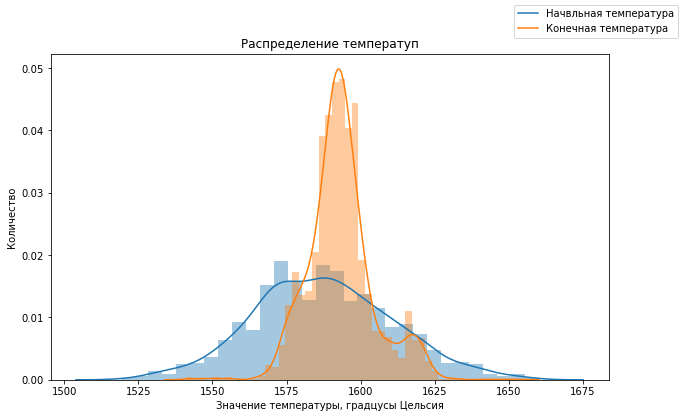

In [98]:
fig = plt.figure(figsize=(10,6))
sns.distplot(df['initial_temperature'].dropna())
sns.distplot(df['final_temperature'].dropna())
plt.xlabel("Значение температуры, градцусы Цельсия")
plt.ylabel("Количество")
plt.title("Распределение температуп")
fig.legend(labels=['Начвльная температура','Конечная температура'])

Как можно видеть из графика, диапазон начпльных температур достаточно широк, а его распределение не имеет острой вершины.

Конечные же температуры, напротив, сконцентрированны чуть выше значения плавления стали и имеют высокую концентрацию.

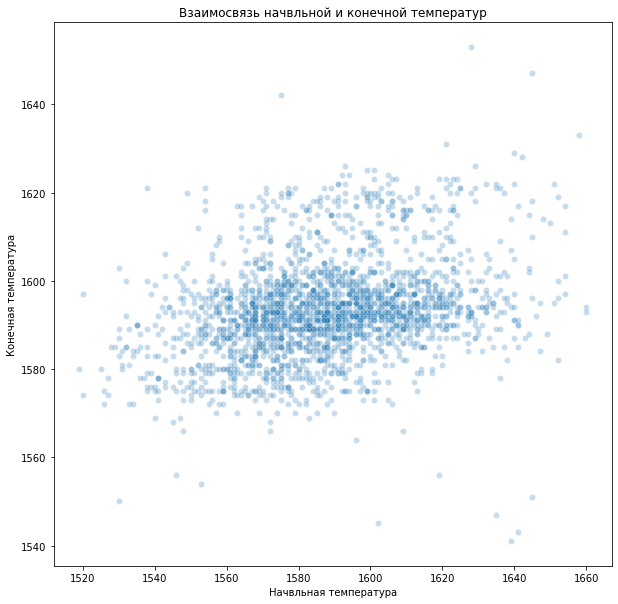

In [99]:
fig = plt.figure(figsize=(10,10))
plt.xlabel('Начвльная температура')
plt.ylabel('Конечная температура')
plt.title("Взаимосвязь начвльной и конечной температур")
sns.scatterplot(data=df,x='initial_temperature', y='final_temperature',alpha=0.25)
plt.show()

Text(0.5, 1.0, 'Распределение энергии')

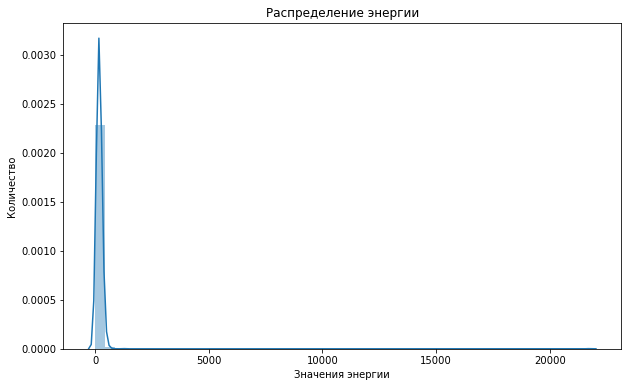

In [100]:
fig = plt.figure(figsize=(10,6))
sns.distplot(df['energy_expended'])
plt.xlabel('Значения энергии')
plt.ylabel("Количество")
plt.title("Распределение энергии")

Как можно видеть, в основном энергии тратится не очень много, но есть ряд редких искоючений.

In [101]:
df[df['energy_expended'] > 1000]

key  number_of_measurements  initial_temperature  final_temperature  \
1578  1689                      16               1583.0             1606.0   
1981  2116                       5               1579.0             1578.0   

      energy_expended  bulk_1  bulk_2  bulk_3  bulk_4  bulk_5  bulk_6  bulk_7  \
1578      1262.890503     0.0     0.0     0.0     0.0     0.0   247.0     0.0   
1981     21738.354678     0.0     0.0     0.0     0.0     0.0   137.0     0.0   

      bulk_8  bulk_9  bulk_10  bulk_11  bulk_12  bulk_13  bulk_14  bulk_15  \
1578     0.0     0.0      0.0      0.0    733.0    305.0    248.0    224.0   
1981     0.0     0.0      0.0      0.0      0.0      0.0    198.0      0.0   

            gas      wire_1  wire_2  wire_3  wire_4  wire_6  wire_7  wire_8  \
1578  33.597044  187.153206     0.0     0.0     0.0     0.0     0.0     0.0   
1981  11.582547   75.216965     0.0     0.0     0.0     0.0     0.0     0.0   

      wire_9  
1578     0.0  
1981     0.0

Есть подозрения, что у нас есть, как минимум один или даже два кандидата на выброс.

In [102]:
# Да, уберём два этих выброса.
vybros = True
if vybros:
    df = df[df['energy_expended'] < 1000]

Возможно, его следует выбросить.

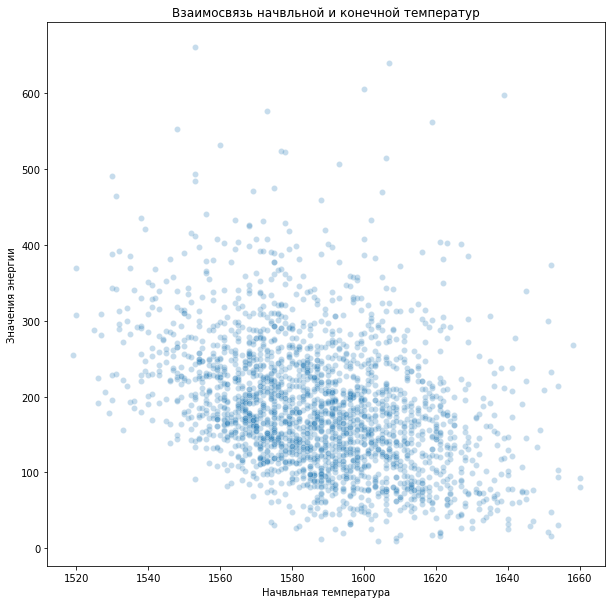

In [103]:
fig = plt.figure(figsize=(10,10))
plt.xlabel('Начвльная температура')
plt.ylabel('Значения энергии')
plt.title("Взаимосвязь начвльной и конечной температур")
sns.scatterplot(data=df,y='energy_expended', x='initial_temperature',alpha=0.25)
plt.show()

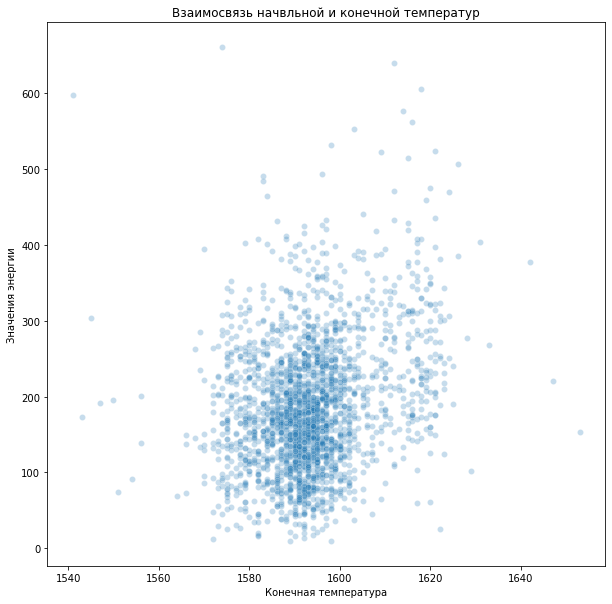

In [104]:
fig = plt.figure(figsize=(10,10))
plt.xlabel('Конечная температура')
plt.ylabel('Значения энергии')
plt.title("Взаимосвязь начвльной и конечной температур")
sns.scatterplot(data=df,y='energy_expended', x='final_temperature',alpha=0.25)
plt.show()

Стало намного лучше.

#### 1.4.3. Корреляционный анализ

Проверим наши данные на мультиколлинеарность.

<AxesSubplot:>

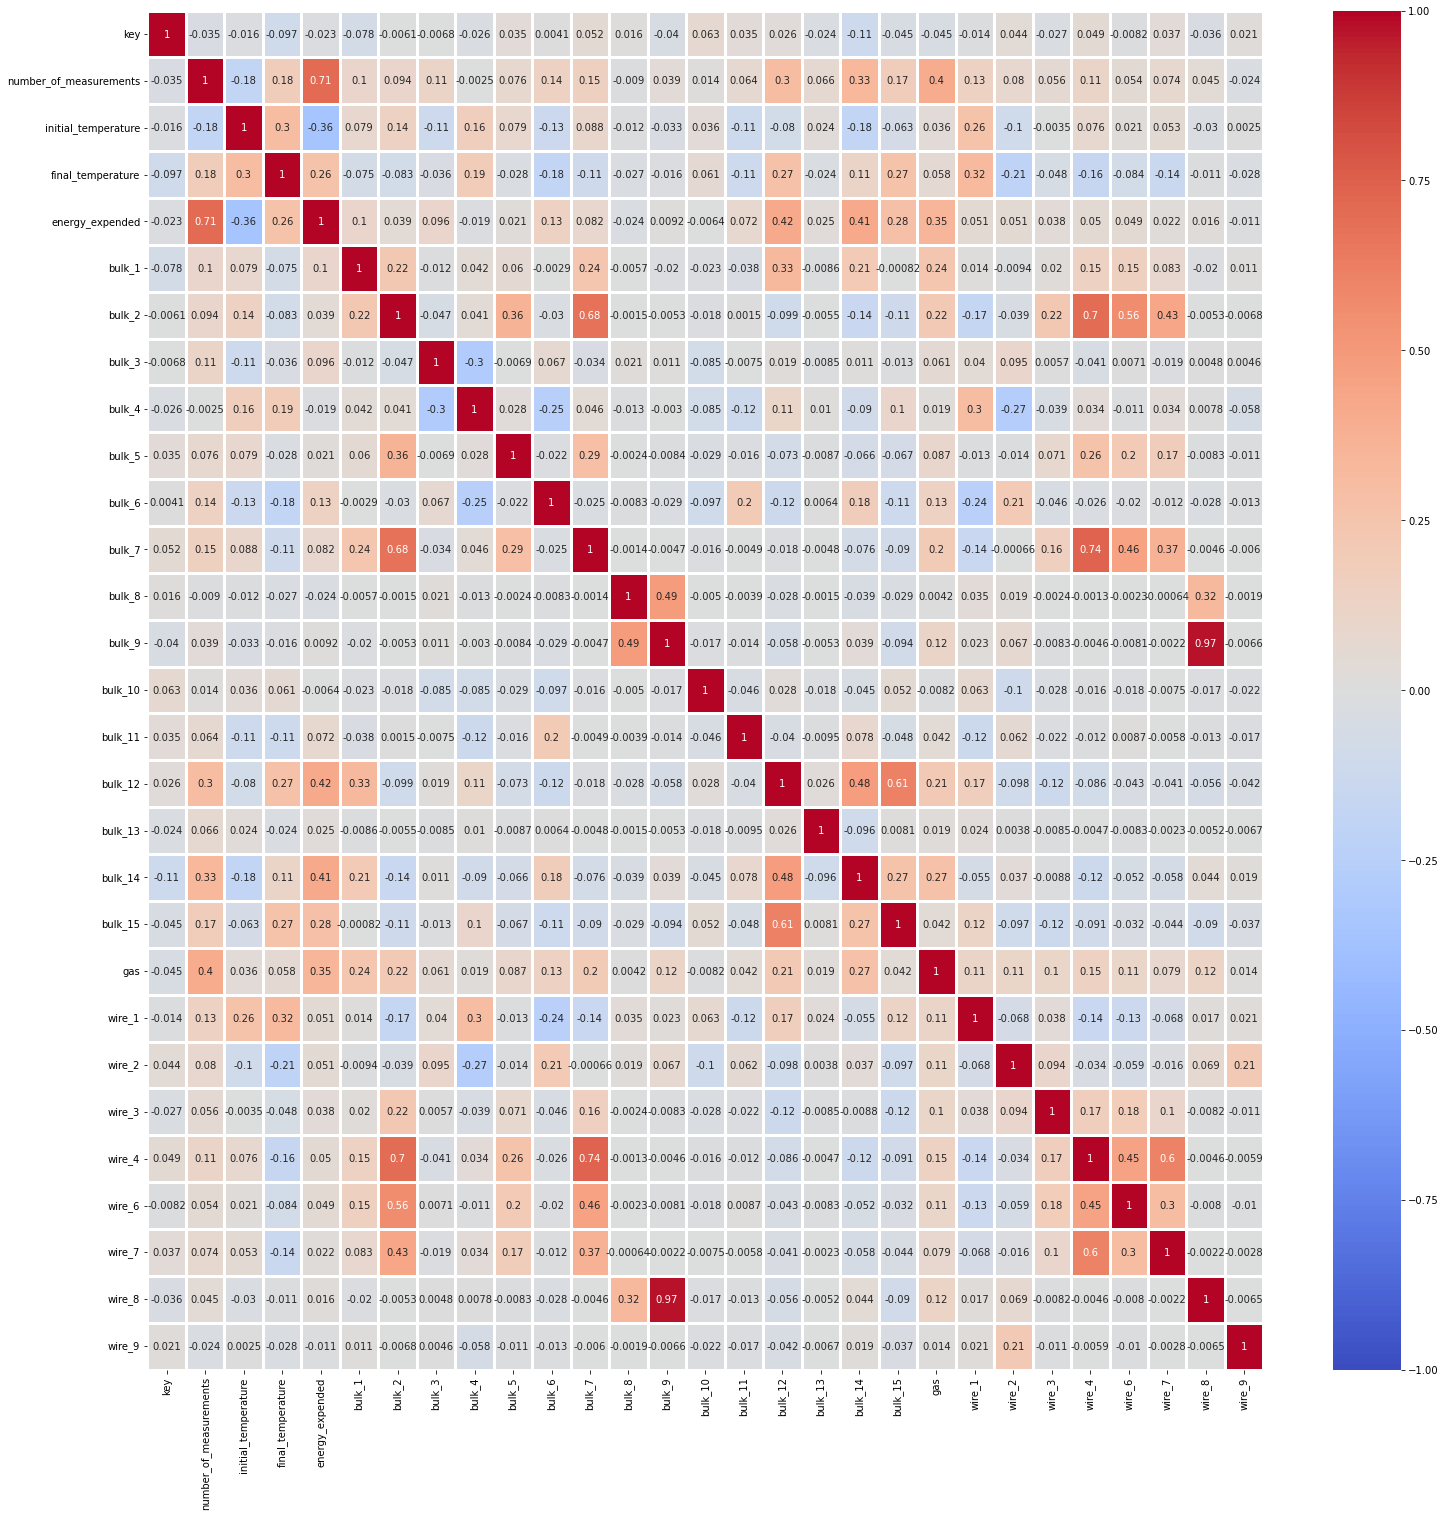

In [105]:
plt.rcParams['figure.figsize'] = (25, 25)
sns.heatmap(df.corr(), annot=True, linewidths=3, cmap='coolwarm', vmin=-1, vmax=1)

Найдем только те параметры, у которых корреляция превышает 0,6 по модулю.

In [106]:
corr_table = df.corr().unstack().sort_values().drop_duplicates()

corr_table[(corr_table > 0.6) | (corr_table < -0.6)]

wire_7           wire_4                    0.602964
bulk_15          bulk_12                   0.614077
bulk_2           bulk_7                    0.679354
wire_4           bulk_2                    0.699341
energy_expended  number_of_measurements    0.707289
wire_4           bulk_7                    0.740571
bulk_9           wire_8                    0.974969
key              key                       1.000000
dtype: float64

Имеется очень высокая корреляция между признаками bulk_9 и wire_8. В этой ситуации лучше удалить из датасета один из этих признаков, чтобы улучшмить результаты работы моделей. Поскольку количество сыпучих материалов больше, чем количество проволочных материалов, то исключим признак bulk_9.

In [107]:
df = df.drop(['bulk_9'], axis=1)

#### 1.4.4.  Выводы

В ходе анализа итоговой таблицы мы:

* Первичный анализ итоговой таблицы выявил одну отсутствующий материал, признак которого можно спокойно удалить.
* Обнаружили и удалили пару выбросов.
* Корреляционный анализ выявиз сильную взаимосвясь между парой переменных, одну из которых пришлось исклюсить, чтобы улучшить работу моделей.

### 1.5. Выводы по разделу:

* Данные ноомально загружены;
* В данных по реактивной мощности есть подозрение на выброс;
* У материалов замечены пропуски в данных, которые вполне можно заполнить нулями;
* У замеров температуры удалены данные с пропусками, т.к. они не несуть информации;
* Во многих данных имеется определённое число забракованных партий, данные по которым отсутствуют. Лучше всего представлены данные по продувке газом.
* Для удобства анализа некоторые наименования столбцов были скорректированы.
* Данные о времени добавления сыпучих и проволочных материалов не нужны.

* У реактивной мощности был обнаружен выброс. Он был заменём на среднее по партии
* У температуры был обнаружен выброс. Он был удалён.
* У данных по объёмам подаче сыпучих и проволочны материалов также были обнаружен выбросы у ряда признаков. Но удалять их мы не стали, т.к. это в этом нет необходимости.

* Все пропуски, где необходимо, удалены или заполнены;
* Дубликаты отсутствуют;
* Создан итоговый датасет с подготовленными данными.

* Первичный анализ итоговой таблицы выявил одну отсутствующий материал, признак которого можно спокойно удалить.
* Обнаружили и удалили пару выбросов.
* Корреляционный анализ выявиз сильную взаимосвясь между парой переменных, одну из которых пришлось исклюсить, чтобы улучшить работу моделей.

## 2. Построение модели машинного обучения

### 2.1. Обучение модели

#### 2.1.1. Выделение признаков и таргета

 Исключаем из датасета данные по номеру партии и количеству замеров по температуре.

In [108]:
# удаляем номер партии, количество её упоминаний и конечную температуру
features = df.drop(['key', 'number_of_measurements','final_temperature'], axis=1)
# выделяем конечную температуру как целевой признак
target = df['final_temperature']

#### 2.1.2. Разделение данных на обучающую и тестовую выборки

Получим обучающую и тестовую выборки. Валидационную выборку не выделяем, т.к. будем применять кросс-валидацию внутри GridSearchCV.

In [109]:
# разделим выборки в пропорции 25 к 75
features_train, features_test, target_train, target_test = train_test_split(
features, target, test_size=0.25, random_state = 24042023)

Проверим результат.

In [110]:
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(1745, 25)
(582, 25)
(1745,)
(582,)


#### 2.1.3. Масштабирование данных

Выборки получены, проведем масштабирование данных с помощью StandardScaler.

In [111]:
numeric = features_train.columns
scaler = StandardScaler()
scaler.fit(features_train[numeric])
    
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

Проверим результат.

In [112]:
features_train.describe()

initial_temperature  energy_expended        bulk_1        bulk_2  \
count         1.745000e+03     1.745000e+03  1.745000e+03  1.745000e+03   
mean         -1.442017e-16    -4.090965e-17 -9.384407e-17 -2.220764e-16   
std           1.000287e+00     1.000287e+00  1.000287e+00  1.000287e+00   
min          -2.882327e+00    -2.034005e+00 -2.892408e-01 -8.279419e-02   
25%          -7.173157e-01    -6.905063e-01 -2.892408e-01 -8.279419e-02   
50%          -3.809660e-02    -1.343068e-01 -2.892408e-01 -8.279419e-02   
75%           6.411225e-01     5.799929e-01 -2.892408e-01 -8.279419e-02   
max           3.060841e+00     5.567137e+00  7.655109e+00  1.520690e+01   

             bulk_3        bulk_4        bulk_5        bulk_6        bulk_7  \
count  1.745000e+03  1.745000e+03  1.745000e+03  1.745000e+03  1.745000e+03   
mean   4.884345e-16  3.410198e-16 -9.331918e-17 -3.768396e-16 -3.961174e-16   
std    1.000287e+00  1.000287e+00  1.000287e+00  1.000287e+00  1.000287e+00   
min   -6.322445e-01 -6.381187e-01 -1.226473e-01 -4.036839e-01 -6.982945e-02   
25%   -6.322445e-01 -6.381187e-01 -1.226473e-01 -4.036839e-01 -6.982945e-02   
50%   -6.322445e-01 -6.381187e-01 -1.226473e-01 -4.036839e-01 -6.982945e-02   
75%    4.205913e-01  6.991511e-01 -1.226473e-01 -4.036839e-01 -6.982945e-02   
max    5.342599e+00  4.093759e+00  2.462874e+01  6.310502e+00  2.003529e+01   

             bulk_8       bulk_10       bulk_11       bulk_12       bulk_13  \
count  1.745000e+03  1.745000e+03  1.745000e+03  1.745000e+03  1.745000e+03   
mean  -1.747567e-16  1.138217e-16 -1.067277e-16  3.575618e-17  1.761724e-16   
std    1.000287e+00  1.000287e+00  1.000287e+00  1.000287e+00  1.000287e+00   
min   -2.394566e-02 -2.379113e-01 -1.941810e-01 -1.342388e+00 -7.408563e-02   
25%   -2.394566e-02 -2.379113e-01 -1.941810e-01 -6.540382e-01 -7.408563e-02   
50%   -2.394566e-02 -2.379113e-01 -1.941810e-01  8.088507e-03 -7.408563e-02   
75%   -2.394566e-02 -2.379113e-01 -1.941810e-01  4.342097e-01 -7.408563e-02   
max    4.176123e+01  7.449254e+00  1.278413e+01  4.249633e+00  2.083323e+01   

            bulk_14       bulk_15           gas        wire_1        wire_2  \
count  1.745000e+03  1.745000e+03  1.745000e+03  1.745000e+03  1.745000e+03   
mean   6.171440e-18 -8.271002e-18  2.697619e-17  2.824865e-17  5.509760e-17   
std    1.000287e+00  1.000287e+00  1.000287e+00  1.000287e+00  1.000287e+00   
min   -1.851592e+00 -1.411753e+00 -1.802646e+00 -2.346653e+00 -5.273574e-01   
25%   -5.715333e-01 -1.411753e+00 -6.534808e-01 -6.972279e-01 -5.273574e-01   
50%   -2.997007e-02 -1.464502e-01 -1.889604e-01 -1.530779e-02 -5.273574e-01   
75%    6.469839e-01  1.000600e+00  4.448253e-01  5.841198e-01  1.769367e-01   
max    3.416341e+00  2.573359e+00  8.020157e+00  5.208276e+00  6.513749e+00   

             wire_3        wire_4        wire_6        wire_7        wire_8  \
count  1.745000e+03  1.745000e+03  1.745000e+03  1.745000e+03  1.745000e+03   
mean  -1.380621e-17  1.847138e-16  2.134396e-16  1.660404e-16 -1.897400e-16   
std    1.000287e+00  1.000287e+00  1.000287e+00  1.000287e+00  1.000287e+00   
min   -1.112950e-01 -7.139874e-02 -1.191415e-01 -3.573534e-02 -7.135261e-02   
25%   -1.112950e-01 -7.139874e-02 -1.191415e-01 -3.573534e-02 -7.135261e-02   
50%   -1.112950e-01 -7.139874e-02 -1.191415e-01 -3.573534e-02 -7.135261e-02   
75%   -1.112950e-01 -7.139874e-02 -1.191415e-01 -3.573534e-02 -7.135261e-02   
max    1.456516e+01  2.086323e+01  1.979684e+01  3.570314e+01  2.171080e+01   

             wire_9  
count  1.745000e+03  
mean   2.477006e-16  
std    1.000287e+00  
min   -9.312308e-02  
25%   -9.312308e-02  
50%   -9.312308e-02  
75%   -9.312308e-02  
max    1.748892e+01

In [113]:
features_test.describe()

initial_temperature  energy_expended      bulk_1      bulk_2  \
count           582.000000       582.000000  582.000000  582.000000   
mean             -0.085872         0.086200    0.027975   -0.063232   
std               1.009562         1.003116    1.264383    0.471921   
min              -2.924778        -2.007916   -0.289241   -0.082794   
25%              -0.759767        -0.568611   -0.289241   -0.082794   
50%              -0.080548        -0.025245   -0.289241   -0.082794   
75%               0.588059         0.582057   -0.289241   -0.082794   
max               2.975938         5.324914   15.685810   11.302149   

           bulk_3      bulk_4      bulk_5      bulk_6      bulk_7  \
count  582.000000  582.000000  582.000000  582.000000  582.000000   
mean    -0.034326    0.007922   -0.056704    0.052341    0.000820   
std      0.964555    1.022469    0.618225    1.148330    1.261117   
min     -0.632245   -0.638119   -0.122647   -0.403684   -0.069829   
25%     -0.632245   -0.638119   -0.122647   -0.403684   -0.069829   
50%     -0.632245   -0.638119   -0.122647   -0.403684   -0.069829   
75%      0.341629    0.677721   -0.122647   -0.403684   -0.069829   
max      4.566133    4.179482   10.385405    9.003657   26.876617   

             bulk_8     bulk_10     bulk_11     bulk_12     bulk_13  \
count  5.820000e+02  582.000000  582.000000  582.000000  582.000000   
mean  -2.394566e-02    0.026335   -0.071997    0.092096   -0.014386   
std    1.597318e-16    1.045887    0.696348    1.102120    0.830101   
min   -2.394566e-02   -0.237911   -0.194181   -1.342388   -0.074086   
25%   -2.394566e-02   -0.237911   -0.194181   -0.647483   -0.074086   
50%   -2.394566e-02   -0.237911   -0.194181    0.008089   -0.074086   
75%   -2.394566e-02   -0.237911   -0.194181    0.668576   -0.074086   
max   -2.394566e-02    7.207520    7.476704   10.779121   11.582872   

          bulk_14     bulk_15         gas      wire_1      wire_2      wire_3  \
count  582.000000  582.000000  582.000000  582.000000  582.000000  582.000000   
mean     0.165312    0.027190    0.113712   -0.016532    0.034189    0.048480   
std      0.997847    1.001995    1.104568    0.981259    1.087702    1.241353   
min     -1.851592   -1.411753   -1.801308   -2.346653   -0.527357   -0.111295   
25%     -0.411526   -1.411753   -0.588036   -0.628383   -0.527357   -0.111295   
50%      0.019263   -0.146450   -0.132311   -0.056947   -0.527357   -0.111295   
75%      0.730065    1.000600    0.614900    0.562444    0.140713   -0.111295   
max      5.976458    3.377476   10.770495    3.191630    8.070899   11.065010   

           wire_4      wire_6        wire_7      wire_8      wire_9  
count  582.000000  582.000000  5.820000e+02  582.000000  582.000000  
mean    -0.058670   -0.044063 -3.573534e-02   -0.021225   -0.012617  
std      0.307078    0.826746  1.666767e-16    0.697019    0.918229  
min     -0.071399   -0.119142 -3.573534e-02   -0.071353   -0.093123  
25%     -0.071399   -0.119142 -3.573534e-02   -0.071353   -0.093123  
50%     -0.071399   -0.119142 -3.573534e-02   -0.071353   -0.093123  
75%     -0.071399   -0.119142 -3.573534e-02   -0.071353   -0.093123  
max      7.336747   15.899249 -3.573534e-02    9.718821   14.950669

Масштабирование признаков прошло успешно.

#### 2.1.4. Обучение моделей и крос-валидация

Определять оптимальные параметры для каждой модели будем с помощью GridSearchCV. Будем брать 5 фолдов для кросс-валидации, в качестве скорера примем "neg_mean_absolute_error".

In [114]:
# создадим функцию для необходимого скора
def mae_score(target, predictions):
    mae = mean_absolute_error(target, predictions)
    return mae
scorer = make_scorer(mae_score, greater_is_better=False)

Обучим следующие модели:

* Линейная регрессия
* Решающие деревья
* Случайный лес
* Градиентный бустинг - LGBM
* Градиентный бустинг - CatBoost
* Константная модель

**Код обучения ряда моделей закавычен, чтоб сэкономить время**

In [115]:
# создадим таблицу для хранения результатов
d = {'model': [], 'MAE':[]}
results = pd.DataFrame(data=d)
results

Empty DataFrame
Columns: [model, MAE]
Index: []

##### 2.1.4.1. Обучение модели линейной регрессии

In [116]:
# линейная регрессия
model_name = "Линейная регрессия"
linear = LinearRegression()
linear_parameters = {'fit_intercept':[True,False], 'normalize':[True,False]}
linear_grid = GridSearchCV(linear, linear_parameters, cv=5, scoring=scorer, verbose=5)
linear_grid.fit(features_train, target_train)
mae = -linear_grid.best_score_
print("MAE линейной регрессии составляет ", mae)
print('Наилучшие подобранные параметры для линейной регрессии')
linear_grid.best_params_

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END fit_intercept=True, normalize=True;, score=-6.528 total time=   0.0s
[CV 2/5] END fit_intercept=True, normalize=True;, score=-7.222 total time=   0.0s
[CV 3/5] END fit_intercept=True, normalize=True;, score=-6.538 total time=   0.0s
[CV 4/5] END fit_intercept=True, normalize=True;, score=-6.160 total time=   0.0s
[CV 5/5] END fit_intercept=True, normalize=True;, score=-6.542 total time=   0.0s
[CV 1/5] END fit_intercept=True, normalize=False;, score=-6.528 total time=   0.0s
[CV 2/5] END fit_intercept=True, normalize=False;, score=-7.222 total time=   0.0s
[CV 3/5] END fit_intercept=True, normalize=False;, score=-6.538 total time=   0.0s
[CV 4/5] END fit_intercept=True, normalize=False;, score=-6.160 total time=   0.0s
[CV 5/5] END fit_intercept=True, normalize=False;, score=-6.542 total time=   0.0s
[CV 1/5] END fit_intercept=False, normalize=True;, score=-1620.181 total time=   0.0s
[CV 2/5] END fit_intercept=Fa

{'fit_intercept': True, 'normalize': True}

In [117]:
results.loc[len(results)] = [model_name, mae]

##### 2.1.4.2. Обучение модели решающего дерева

Используем модель решающих деревьев.

In [118]:
# Решающее дерево
model_name = "Решающее дерево"
tree = DecisionTreeRegressor(random_state=24042023)
tree_params = {'max_depth': range(1,11),
               'min_samples_leaf': range(5, 50, 5)}
tree_grid = GridSearchCV(tree, tree_params,
                         cv=5, verbose=5, scoring=scorer)
tree_grid.fit(features_train, target_train)
mae = -tree_grid.best_score_
print("MAE для решающего дерева составляет ", mae)
print('Наилучшие подобранные параметры для решающего дерева')
print(tree_grid.best_params_)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
[CV 1/5] END ..max_depth=1, min_samples_leaf=5;, score=-8.026 total time=   0.0s
[CV 2/5] END ..max_depth=1, min_samples_leaf=5;, score=-8.848 total time=   0.0s
[CV 3/5] END ..max_depth=1, min_samples_leaf=5;, score=-8.513 total time=   0.0s
[CV 4/5] END ..max_depth=1, min_samples_leaf=5;, score=-7.521 total time=   0.0s
[CV 5/5] END ..max_depth=1, min_samples_leaf=5;, score=-8.049 total time=   0.0s
[CV 1/5] END .max_depth=1, min_samples_leaf=10;, score=-8.026 total time=   0.0s
[CV 2/5] END .max_depth=1, min_samples_leaf=10;, score=-8.848 total time=   0.0s
[CV 3/5] END .max_depth=1, min_samples_leaf=10;, score=-8.320 total time=   0.0s
[CV 4/5] END .max_depth=1, min_samples_leaf=10;, score=-7.521 total time=   0.0s
[CV 5/5] END .max_depth=1, min_samples_leaf=10;, score=-8.049 total time=   0.0s
[CV 1/5] END .max_depth=1, min_samples_leaf=15;, score=-8.026 total time=   0.0s
[CV 2/5] END .max_depth=1, min_samples_leaf=15;

In [119]:
results.loc[len(results)] = [model_name, mae]

##### 2.1.4.3. Обучение модели случайного леса

Используем модель случайного леса.

In [120]:
'''# "Случайный лес"
model_name = "Случайный лес"
forest = RandomForestRegressor(random_state=24042023)
forest_params = {'n_estimators': range(30, 101, 10),
                 'max_depth': range(1,11)}
forest_grid = GridSearchCV(forest, forest_params,
                         cv=5, verbose=5, scoring=scorer)
forest_grid.fit(features_train, target_train)
mae = -forest_grid.best_score_
print("MAE для случайного леса составляет ", mae)
print('Наилучшие подобранные параметры для случайного леса')
print(forest_grid.best_params_)'''

'# "Случайный лес"\nmodel_name = "Случайный лес"\nforest = RandomForestRegressor(random_state=24042023)\nforest_params = {\'n_estimators\': range(30, 101, 10),\n                 \'max_depth\': range(1,11)}\nforest_grid = GridSearchCV(forest, forest_params,\n                         cv=5, verbose=5, scoring=scorer)\nforest_grid.fit(features_train, target_train)\nmae = -forest_grid.best_score_\nprint("MAE для случайного леса составляет ", mae)\nprint(\'Наилучшие подобранные параметры для случайного леса\')\nprint(forest_grid.best_params_)'

In [121]:
mae = 6.508471693466942
results.loc[len(results)] = [model_name, mae]

##### 2.1.4.4. Обучение модели градиентного бустинга с перебором гиперпараметров - LGBM

In [122]:
'''# LGBM
model_name = "LGBM"
gbm = LGBMRegressor(random_state=24042023)
g_params = {'n_estimators': [50, 100, 500],
              'num_leaves': [21, 31, 41], 
              'learning_rate':[0.01, .04, 0.06]}
g_grid = GridSearchCV(gbm, g_params,
                         cv=5, verbose=5, scoring=scorer)
g_grid.fit(features_train, target_train)
mae = -g_grid.best_score_
print("MAE для LGBM составляет ", mae)
print('Наилучшие подобранные параметры для LGBM')
print(g_grid.best_params_)'''

'# LGBM\nmodel_name = "LGBM"\ngbm = LGBMRegressor(random_state=24042023)\ng_params = {\'n_estimators\': [50, 100, 500],\n              \'num_leaves\': [21, 31, 41], \n              \'learning_rate\':[0.01, .04, 0.06]}\ng_grid = GridSearchCV(gbm, g_params,\n                         cv=5, verbose=5, scoring=scorer)\ng_grid.fit(features_train, target_train)\nmae = -g_grid.best_score_\nprint("MAE для LGBM составляет ", mae)\nprint(\'Наилучшие подобранные параметры для LGBM\')\nprint(g_grid.best_params_)'

In [123]:
mae = 6.596685002013049
results.loc[len(results)] = [model_name, mae]

##### 2.1.4.5. Обучение модели градиентного бустинга с перебором гиперпараметров - CatBoost

In [124]:
# CatBoostо
model_name = "CatBoostо"
cbr = CatBoostRegressor(loss_function="MAE", random_state=24042023)
grid = {'learning_rate': [0.03, 0.1, 0.5],
        'iterations': [150, 500]}
cbr_grid = GridSearchCV(cbr, grid,
                         cv=5, verbose=5, scoring=scorer)
cbr_grid.fit(features_train, target_train)
mae = -cbr_grid.best_score_
print("MAE для CatBoost составляет ", mae)
print('Наилучшие подобранные параметры для CatBoost')
print(cbr_grid.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
0:	learn: 8.0739460	total: 142ms	remaining: 21.1s
1:	learn: 8.0303368	total: 143ms	remaining: 10.6s
2:	learn: 7.9819603	total: 144ms	remaining: 7.07s
3:	learn: 7.9221702	total: 146ms	remaining: 5.31s
4:	learn: 7.8629328	total: 147ms	remaining: 4.26s
5:	learn: 7.8182974	total: 148ms	remaining: 3.55s
6:	learn: 7.7746503	total: 149ms	remaining: 3.04s
7:	learn: 7.7408445	total: 150ms	remaining: 2.67s
8:	learn: 7.7079918	total: 151ms	remaining: 2.37s
9:	learn: 7.6621595	total: 153ms	remaining: 2.13s
10:	learn: 7.6266822	total: 154ms	remaining: 1.94s
11:	learn: 7.5867077	total: 155ms	remaining: 1.78s
12:	learn: 7.5590846	total: 156ms	remaining: 1.64s
13:	learn: 7.5190527	total: 157ms	remaining: 1.52s
14:	learn: 7.4898187	total: 158ms	remaining: 1.42s
15:	learn: 7.4483089	total: 159ms	remaining: 1.33s
16:	learn: 7.4147577	total: 161ms	remaining: 1.26s
17:	learn: 7.3640707	total: 162ms	remaining: 1.19s
18:	learn: 7.3281917	total: 163m

In [125]:
mae = 6.337067866825622
results.loc[len(results)] = [model_name, mae]

##### 2.1.4.6. Обучение константной модели

In [126]:
# Константная модель
model_name = "Константная модель"
dummy = DummyRegressor()
dummy_params = {'strategy': ["mean", 'median','constant'],
               'constant': [1400]}
dummy_grid = GridSearchCV(dummy, dummy_params,
                         cv=5, verbose=5, scoring=scorer)
dummy_grid.fit(features_train, target_train)
mae = -dummy_grid.best_score_
print("MAE для константной модели составляет ", mae)
print('Наилучшие подобранные параметры для константной модели')
print(dummy_grid.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END .....constant=1400, strategy=mean;, score=-7.823 total time=   0.0s
[CV 2/5] END .....constant=1400, strategy=mean;, score=-8.748 total time=   0.0s
[CV 3/5] END .....constant=1400, strategy=mean;, score=-8.454 total time=   0.0s
[CV 4/5] END .....constant=1400, strategy=mean;, score=-7.525 total time=   0.0s
[CV 5/5] END .....constant=1400, strategy=mean;, score=-8.028 total time=   0.0s
[CV 1/5] END ...constant=1400, strategy=median;, score=-7.805 total time=   0.0s
[CV 2/5] END ...constant=1400, strategy=median;, score=-8.628 total time=   0.0s
[CV 3/5] END ...constant=1400, strategy=median;, score=-8.387 total time=   0.0s
[CV 4/5] END ...constant=1400, strategy=median;, score=-7.527 total time=   0.0s
[CV 5/5] END ...constant=1400, strategy=median;, score=-8.009 total time=   0.0s
[CV 1/5] END constant=1400, strategy=constant;, score=-193.900 total time=   0.0s
[CV 2/5] END constant=1400, strategy=constant;, 

In [127]:
results.loc[len(results)] = [model_name, mae]

#### 2.1.5. Выбор лучшей модели

Выведем результаты на кросс-валидации для всех моделей.

In [128]:
results

model       MAE
0  Линейная регрессия  6.598123
1     Решающее дерево  7.371440
2     Решающее дерево  6.508472
3     Решающее дерево  6.596685
4           CatBoostо  6.337068
5  Константная модель  8.071060

**Вывод по проведенному обучению моделей:**

Наихудший результат совершенно естественно показала константная модель. Также очень плохой результат показала модель решающего дерева с MAE 7.371440.

Все остальные обученные модели прошли минимальный порог в 6.8 MAE внутри кросс-валидации. 

Высркую оценку получили модели линейной регрессии и LGBM с MAE около 6.59.

Ещё лучше показала себя модель случайного леса с MAE 6.50.

Наилучшие результаты на кросс-валидации показала модель градиентного бустинга CatBoostRegressor с MAE 6.3. Проведем проверку работы этой моделей на тестовой выборке.

### 2.2. Проверка лучшей модели

#### 2.2.1. Тестирование лучшей модели на тестовой выборке

Проведём тестирование лучшей модели CatBoost.

In [129]:
# CatBoost
cb = CatBoostRegressor(loss_function="MAE",
                         learning_rate=0.03, 
                         iterations=500,
                         random_state=24042023)

cb.fit(features_train, target_train)
prediction = cb.predict(features_test)
mae = mean_absolute_error(target_test, prediction) 

print("MAE для модели CatBoost составляет ", mae)
print('Наилучшие подобранные параметры для модели CatBoost')
print(cbr_grid.best_params_)

0:	learn: 8.0066409	total: 1.55ms	remaining: 775ms
1:	learn: 7.9473590	total: 2.87ms	remaining: 715ms
2:	learn: 7.8975829	total: 4.16ms	remaining: 689ms
3:	learn: 7.8587664	total: 5.43ms	remaining: 674ms
4:	learn: 7.8240075	total: 6.84ms	remaining: 678ms
5:	learn: 7.7813289	total: 8.03ms	remaining: 661ms
6:	learn: 7.7310167	total: 9.28ms	remaining: 654ms
7:	learn: 7.6905492	total: 10.4ms	remaining: 642ms
8:	learn: 7.6365182	total: 11.6ms	remaining: 632ms
9:	learn: 7.5880602	total: 12.7ms	remaining: 624ms
10:	learn: 7.5339322	total: 13.9ms	remaining: 619ms
11:	learn: 7.5039634	total: 15ms	remaining: 610ms
12:	learn: 7.4668983	total: 16.2ms	remaining: 605ms
13:	learn: 7.4305236	total: 17.6ms	remaining: 610ms
14:	learn: 7.3995352	total: 18.7ms	remaining: 606ms
15:	learn: 7.3598159	total: 19.8ms	remaining: 600ms
16:	learn: 7.3277999	total: 21ms	remaining: 598ms
17:	learn: 7.3033236	total: 22.3ms	remaining: 598ms
18:	learn: 7.2676767	total: 23.5ms	remaining: 595ms
19:	learn: 7.2303401	total

И на тестовой выборке модель CatBoost показала отличный результат (MAE = 6.327).

Text(0, 0.5, 'Предсказанные значения')

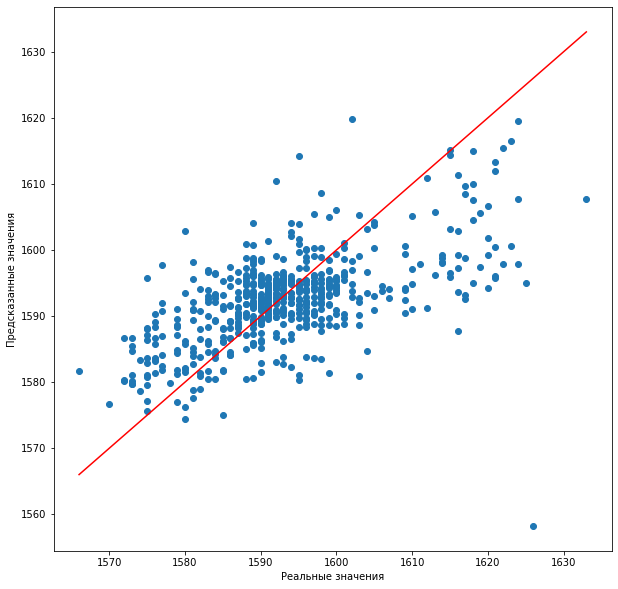

In [130]:
plt.figure(figsize=(10,10))

plt.scatter(target_test, prediction)
plt.plot([min(target_test),max(target_test)],[min(target_test), max(target_test)], color='r')
plt.xlabel('Реальные значения')
plt.ylabel('Предсказанные значения')

Как видим, несмотря на хорошую метрику качества, модель далеко не всегда точна, и нам есть ещё над чем работать.

#### 2.2.2. Если MAE на тестовых данных > 6.8 - доработка модели

Модель проходит тест - доработка не нужна.

#### 2.2.3. Анализ важности факторов

##### 2.2.3.1. Standart SHAP values

Применим метод SHAP для анализ важности факторов.

In [131]:
#Get shap values
explainer = shap.Explainer(cb)
shap_values = explainer(features)

##### 2.2.3.2. Waterfall plot

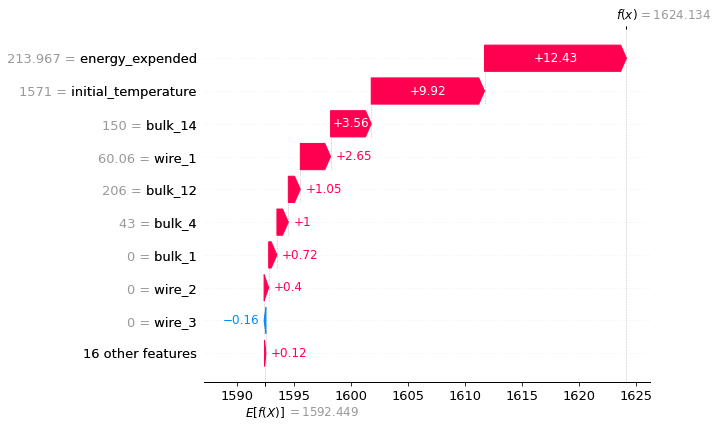

In [132]:
# Waterfall plot for first observation
shap.plots.waterfall(shap_values[0])

##### 2.2.3.2. Force plot

In [133]:
shap.plots.force(shap_values[0])

In [134]:
shap.plots.force(shap_values)

Есть интересная зависимость от номера партии, что может быть связано с другой переменной, а именно со временем, т.е. сезонностью или бригадой, исполняющей заказ.

##### 2.2.3.3. Гистограмма важности

Посмотрим, какие признаки наиболее важные.

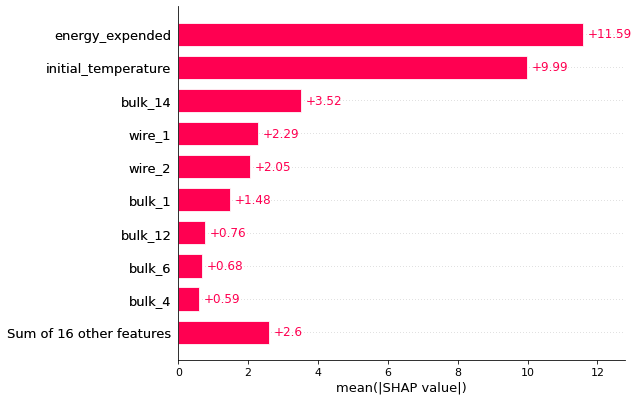

In [135]:
#Mean SHAP
shap.plots.bar(shap_values)

Из графика видно, что наибольшее значение для предсказания температуры имеют энергия и начальная температура. Менее значительными оказались проволочные материалы `wire_1` и `wire_2` и сыпучих материалов `bulk_1` и `bulk_14`.

##### 2.2.3.4. Beeswarm plot

Как его читать:

* значения слева от центральной вертикальной линии — это negative класс (0), справа — positive (1)
* чем толще линия на графике, тем больше таких точек наблюдения
* чем краснее точки на графике, тем выше значения фичи в ней.

Визуализируем средние значения средних значений.

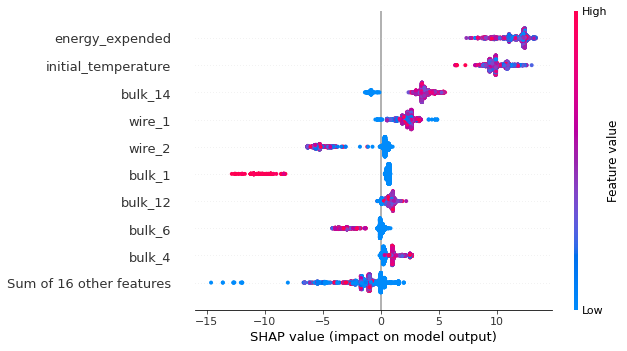

In [136]:
# Beeswarm plot
shap.plots.beeswarm(shap_values)

Нет никакой прямолинейной зависимости между признаками и точностью модели.

Признаки `bulk_14` и `wire_1` имеют положительное влияние на предсказательную способность нашей модели.

Признаки `bulk_4` и `bulk_12` в целом не оказывают положительного или отрицательного эффекта на модель.

Из графика видно, что большие концентрации `bulk_1` отрицательно сказываются на прогнозе модели. Признак `bulk_6`, `wire_2` и остальные 16 признаков также не улучшают нашу модель.

##### 2.2.3.5. Dependence plot

Посмотрим на графики зависимостей переменных и важности признаков.

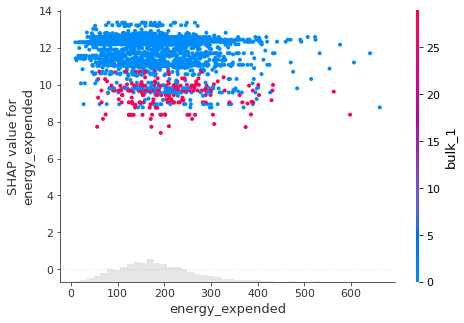

In [137]:
#Plot 1: energy_expended
shap.plots.scatter(shap_values[:,"energy_expended"], color=shap_values)

Чётких взаимосвязей не выявлено.

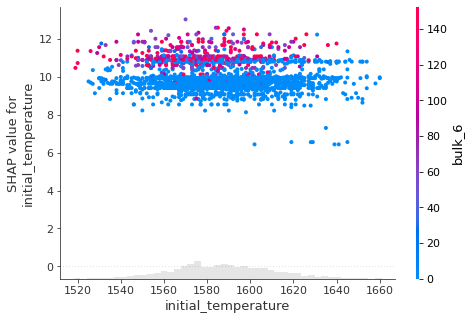

In [138]:
#Plot 2: initial_temperature
shap.plots.scatter(shap_values[:,"initial_temperature"], color=shap_values)

Чётких взаимосвязей не выявлено.

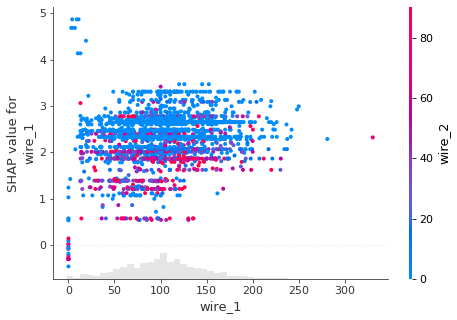

In [139]:
#Plot 3: shell weight
shap.plots.scatter(shap_values[:,"wire_1"], color=shap_values)

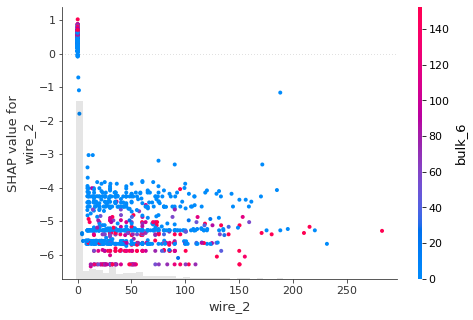

In [140]:
#Plot 4: shell weight
shap.plots.scatter(shap_values[:,"wire_2"], color=shap_values)

Чётких взаимосвязей не выявлено.

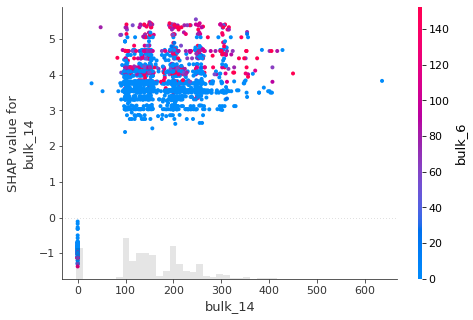

In [141]:
#Plot 5: shell weight
shap.plots.scatter(shap_values[:,"bulk_14"], color=shap_values)

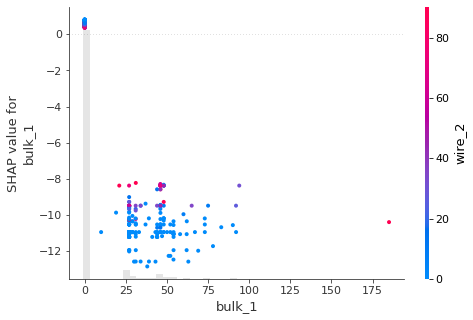

In [142]:
#Plot 6: shell weight
shap.plots.scatter(shap_values[:,"bulk_1"], color=shap_values)

Чётких взаимосвязей не выявлено.

### 2.3. Выводы

В данном разделе мы:

* Разделили данные на признаки и целевое значение.
* Маштабировали признаки.
* Разделили данные на обучающую и тестовую выборку в отношении 3:1.
* Обучили шесть моделей методом кросс-валидации.
* Выбрали наилучшую модель (CatBoost) и проверили её на тестовой выборке.
* Проанализировали важность признаков.

## 3. Отчёт. Общий вывод

### 3.1. Пункты плана

В ходе работы над проектом прогнозирования температуры стали все пункты плана были выполнены. 
Мы произвели:

* Загрузку данных;
* Разведывательный анализ данных (EDA), включая первичное знакомствои и визуальный анализ;
* Предобработка данных, включая заполнение пропусков и борьба с выбросами;
* Объединение данных и анализ итоговой таблицы;
* Масштабирование данных, поскольку все из них бфли количественные;
* Обучение моделий выбор лучшей с последующей проверкой на тестовой выборке;
* Анализ важности признаков модели.

Все эти пункты были выполнены, поскольку былм результвтом вдумчивой работы и у нас не возникло лишних проблем с данными, их низким качество, загрузкой, бвлвнсом и полнотой после удаления лишних признаков и записей. В эти пункты традиционны для анализа данных и в совокупности дают хороших эффект для успешной работы.

### 3.2. Преодолённые трудности

В рамках работы с данными перед нами возникли следующие трудности:

* изменение типов данных для временных переменных;
* пропущенные значения - для одних данных мы просто удалили записи с отсутствующими данными (конечная температура), а для других - заполнили пропуски нулями (сыпучме и проволочные материалы);
* неполнота некоторых данных - вы добавили два новых признака (полная мощность и энергия);
* выбросы - для одних данные (реактивная мощность) мы заменили выброс средним значением по признаку без выброса, а в друних (энергия);
* мультиколлениарность - два признака оказались сильно скоррелированными в результате чего мы удалили один из них;
* 

### 3.3. Ключевые шаги

#### 3.3.1. Первичный анализ данных

* Данные ноомально загружены;
* В данных по реактивной мощности есть подозрение на выброс;
* У материалов замечены пропуски в данных, которые вполне можно заполнить нулями;
* У замеров температуры удалены данные с пропусками, т.к. они не несуть информации;
* Во многих данных имеется определённое число забракованных партий, данные по которым отсутствуют. Лучше всего представлены данные по продувке газом.
* Для удобства анализа некоторые наименования столбцов были скорректированы.
* Данные о времени добавления сыпучих и проволочных материалов не нужны.

#### 3.3.2. Визуальный анализ данных

* У реактивной мощности был обнаружен выброс. Он был заменём на среднее по партии
* У температуры был обнаружен выброс. Он был удалён.
* У данных по объёмам подаче сыпучих и проволочны материалов также были обнаружен выбросы у ряда признаков. Но удалять их мы не стали, т.к. это в этом нет необходимости.

#### 3.3.3. Предобработка данных

* Все пропуски, где необходимо, удалены или заполнены;
* Дубликаты отсутствуют;
* Создан итоговый датасет с подготовленными данными.

#### 3.3.4. Анализ итоговой таблицы

В ходе анализа итоговой таблмцы данных мы:

* Выявили один признак отсутствующий материал, признак которого можно спокойно удалить.
* Обнаружили и удалили пару выбросов.
* Корреляционный анализ выявиз сильную взаимосвясь между парой переменных, одну из которых пришлось исклюсить, чтобы улучшить работу моделей.

#### 3.3.5. Обучение модели

В ходе построения модели машинного обучения мы:

* Разделили данные на признаки и целевое значение.
* Маштабировали признаки.
* Разделили данные на обучающую и тестовую выборку в отношении 3:1.

Были обучены шесть моделей машинного обучнения:

* Линейная регрессия
* Решающие деревья
* Случайный лес
* Градиентный бустинг - LGBM
* Градиентный бустинг - CatBoost
* Константная модель

Наихудший результат совершенно естественно показала константная модель. Также очень плохой результат показала модель решающего дерева с MAE 7.371440.

Все остальные обученные модели прошли минимальный порог в 6.8 MAE внутри кросс-валидации.

Высркую оценку получили модели линейной регрессии и LGBM с MAE около 6.59.

Ещё лучше показала себя модель случайного леса с MAE 6.50.

Наилучшие результаты на кросс-валидации показала модель градиентного бустинга CatBoostRegressor с MAE 6.3. Проведем проверку работы этой моделей на тестовой выборке.

* Обучили шесть моделей методом кросс-валидации;
* Выбрали наилучшую модель (CatBoost) и проверили её на тестовой выборке;

#### 3.3.6. Важность признаков:

В ходе анализа важности признаков установлено, что: 

* начальной температуры и энергии важны для прогноза;
* нет никакой прямолинейной зависимости между признаками и точностью модели;
* признаки `bulk_14` и `wire_1` имеют положительное влияние на предсказательную способность нашей модели;
* признаки `bulk_4` и `bulk_12` в целом не оказывают положительного или отрицательного эффекта на модель;
* большие концентрации `bulk_1` отрицательно сказываются на прогнозе модели. * бризнак `bulk_6`, `wire_2` и остальные 16 признаков также не улучшают нашу модель.

### 3.4. Наилучшая модель и её качество

Наилучшие результаты на кросс-валидации показала модель градиентного бустинга CatBoostRegressor. Метрика качества MAE равеа 6.3. Проведем проверку работы этой моделей на тестовой выборке.

### 3.4. Cписок признаков для обучения лучшей модели

Признаки для обучения лучшей модели и их предобработка:

* **Начальная температура** (`initial_temperature`) - не потребовал изменений;
* **Конечная температура**(`final_temperature` ) - при предобработке были удалены записи с пропусками этого целевого признака;
* **Энергия**(`energy_expended`) - этот показатель был рассчитан и добавлен на основе значений времени нагрева и полной мощности, которык затем были удалены как избыточные признаки;
*  **Сыпучие материалы** `bulk_1`, `bulk_2`, `bulk_3`, `bulk_4`, `bulk_5`, `bulk_6`, `bulk_7`, `bulk_8`, `bulk_10`, `bulk_11`, `bulk_12`, `bulk_13`; `bulk_14`, `bulk_15`  - потребовали заполнения пропусков нулями и удаления одного из признаков (а именно `bulk_9`) из-за того, что все его значения в итоговой таблице оказались нулевыми;
* **Подача газа материалы** `gas` - не потребовали предобработки;
* **Проволочные материалы материалы** `wire_1`, `wire_2`, `wire_3`, `wire_4`, `wire_6`, `wire_7`, `wire_8`, `wire_9` - потребовали заполнения пропусков нулями и удаления одного из признаков (а именно `wire_5`) в рамках борьбы с мультиколлениарностью;

Также перед обучением все признаки были масштабированы.

### 3.5. Гиперпараметры лучшей модели

Наилучшие результаты на кросс-валидации показала модель градиентного бустинга CatBoostRegressor с MAE 6.3. 
Проведем проверку работы этой моделей на тестовой выборке.

Гиперпараметры модели следующие:

* **loss_function** = `MAE`;
* **random_state** = `24042023`;
* **learning_rate** = `0.03`;
* **iterations** = `500`;

### 3.6. Рекомендации по улучшению модели, решения

Для улучшения модели можно выбрать несколько направлений:

**Упрощение модели:**
* использовать классификацаю, а не регрессию. Для этого нужно изменить подход с предсказания значения на его тип. Маожно предказывать класс температуры: в пределах необходимых температур (0), выше необходимых значений (1) или ниже (-1). Тогда можно предсказать, будет тот или иной подход экономным и оптимальным или убыточным и неэффективным;
* удалить ряд признаков, важность которых была незначительной по результатам SHAP;
* можно объединить ряд редких материалов в обшие признаки, чтобы уменьшить сложность и размерность модели;

**Усложнение модели:**

* использовать доволнительные данные (бригада, выполняющая работу; химический состав материала или газ; особенности оборудования (электроды, измерители температуры, поставщики материалов и оборудования и т.п.);
* учитывать время операции над партией (часы и минуты, часть дня, день недели, будни или выходные,месяц, время года и т.д.);
* использовать данные о времени добавления материалов и встроить в модель временные ряды;

Как один, так и другой подход могут улучшить качество молеои, упростить её использование и решить задачу заказчика.